# TimePix MZI analysis written by Evan Klein and edited by Trevor Donovan

In [1]:
#fun facts: data was centroided, interferometer was realigned! note, the bins aren't the same as the non-centroided
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import pandas as pd
import pickle

from matplotlib.animation import FuncAnimation
from IPython.display import clear_output

# Initializing variables 

In [2]:
#what assumptions are being made about the sequence of events here? Why are num_exp_pause and num_exposures not here?
cent_csv = "D:\MZ_GaAs_20min_Realign_W0028_H07-240709-163217_cent.csv" # File location of _cent.csv file
exposure_time = 7 # Time in seconds of each exposure in the motor moving code
motorMovementsPerExposure = 10 # Found within the motor moving code
total_time = 20 # Time in units of the time division you choose that the TimePix ran for
bin_period = 1./40. # Time period you want each bin to span over in units of the time division you choose
time_div_label = "min" # Time scale you want to use for plotting choose from: ms, sec, min, hrs, days

In [3]:
# Dictionary defining time scale you want to use for plotting
time_div_dict = {"ms" : 1/60, "sec" : 1, "min" : 60, "hrs" : 3600, "days" : 3600*24}
time_div_val = time_div_dict[time_div_label]

In [2]:
nbins = np.round(total_time / bin_period).astype(int)
print(f"{nbins} bins will be created over {total_time} {time_div_label}, meaning each bin has a period of {total_time/nbins} {time_div_label}")

NameError: name 'np' is not defined

# Importing csv file

## Preview data

In [5]:
# Changing nrows affects how big an initial timechunk you collect (taking more rows takes longer but gives a better visual)
MZI_df_preview = pd.read_csv(cent_csv, nrows=10000000)
MZI_df_preview

#Col  #Row           #ToA  #ToT[arb]  #ToTtotal[arb]  #Centroid  \
0         149   154   158171778560        400             750          3   
1           3   152   158171908864        300             575          2   
2         232   123   158171939072        150             150          1   
3         108   118   158172213248        275             800          3   
4          37     7   158172309760         75              75          1   
...       ...   ...            ...        ...             ...        ...   
9999995   107   169  1679921620736        125             125          1   
9999996   248   152  1679921854720        275             525          3   
9999997   125   248  1679921857536        300             300          1   
9999998    86    97  1679921883648        350             550          3   
9999999   252   141  1679921893376        275             275          1   

            #cent_X     #cent_Y  #centStdev_X  #centStdev_Y  #centStdev_ToA  \
0        149.900000  154.566667      0.700000      0.558768            3172   
1          3.500000  152.978261      0.500000      0.706773             128   
2        232.500000  123.500000      0.500000      0.500000               0   
3        108.781250  118.125000      0.672420      0.695971            2374   
4         37.500000    7.500000      0.500000      0.500000               0   
...             ...         ...           ...           ...             ...   
9999995  107.500000  169.500000      0.500000      0.500000               0   
9999996  248.309524  152.214286      0.635763      0.673856            3499   
9999997  125.500000  248.500000      0.500000      0.500000               0   
9999998   86.681818   97.318182      0.631475      0.631475            2783   
9999999  252.500000  141.500000      0.500000      0.500000               0   

         Unnamed: 11  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
9999995          NaN  
9999996          NaN  
9999997          NaN  
9999998          NaN  
9999999          NaN  

[10000000 rows x 12 columns]

## Creating global bins by getting first and last timestamps

In [6]:
start_time = int(MZI_df_preview.iloc[0]['#ToA'])
print(f"The beginning timestamp is {start_time}.")

The beginning timestamp is 158171778560.


In [7]:
with open(cent_csv, 'rb') as file:
    file.seek(0, 2)  # seek(0, 2) tells the cursor to go 0 spaces away from the end
    file_size = file.tell() # file.tell() gives current cursor position
    pos = file_size - 1
    string = ''
    for i in range(pos):
        char = file.read(1).decode('utf-8') # file.read(1) reads character at current cursor position
        if char == '\n':
            break # Stop collecting characters once first delimeter is found
        string += char
        pos -= 1
        file.seek(pos, 0) # Moves cursor back one
    string = string[::-1] # Reverses order to give correct string of last row   
    print(f"The last row in the csv is: {string}")
    
last_row_arr = string.split(',')
end_time = int(last_row_arr[2]) # ToA should be in the 3rd column
print(f"The final timestamp is {end_time}.")

The last row in the csv is: 122,168,197368907133952,225,425,2,122.500000,168.970588,0.500000,0.706495,256,
The final timestamp is 197368907133952.


In [8]:
hist_bins = np.linspace(start_time, end_time, nbins+1) # nbins+1 is to ensure this is bin edges not just centers
hist_bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2.0 # List of centers of bins (Shorter than bin edges list by 1)

# Converting bin values from arbitrary timestamps to real time from start of experiment
bin_centers_rt = (np.array(hist_bin_centers) - start_time)/(end_time-start_time)*total_time

## Preview image for finding region limits

In [9]:
# Values used to draw box for finding rectangular region around the spot (x-coord, y-coord, x-size, y-size). not used?
region_811_1_vals = [88, 88, 5, 5]
region_811_2_vals = [101, 87, 7, 7]

## Spectrum of Argon:
![Image of Argon spectra](ArSpectra.png)

In [10]:
#generate the following code block easily
x1Xs = [56.6,67.8,76.6,90.1,102.2,115.7,129.,138.7,161.9,169.5,178.7,194.3,210.1,221.]
y1Ys = [108.,108.,108.,108.,108.,108.,108.,107.,106.,106.,106.,106.,106.,106.]

x2Xs = np.array(x1Xs) + 1. 
y2Ys = np.array(y1Ys) + 15.

lLs = [696.54, 706.72, 714.7, 727.29, 738.40, 750.39, 763.51, 772.38, 794.82, 801.48, 811.53, 826.45, 842.46, 852.14]

xr = 3
yr = 3

for i, l in enumerate(lLs):
    print(f'# {l} nm')
    print(f'spot_df.append([{str(l)}, 1, {str(y1Ys[i]-yr)}, {str(2*yr)}, {str(x1Xs[i]-xr)}, {str(2*xr)}])')
    print(f'spot_df.append([{str(l)}, 2, {str(y2Ys[i]-yr)}, {str(2*yr)}, {str(x2Xs[i]-xr)}, {str(2*xr)}])')
    print()

# 696.54 nm
spot_df.append([696.54, 1, 105.0, 6, 53.6, 6])
spot_df.append([696.54, 2, 120.0, 6, 54.6, 6])

# 706.72 nm
spot_df.append([706.72, 1, 105.0, 6, 64.8, 6])
spot_df.append([706.72, 2, 120.0, 6, 65.8, 6])

# 714.7 nm
spot_df.append([714.7, 1, 105.0, 6, 73.6, 6])
spot_df.append([714.7, 2, 120.0, 6, 74.6, 6])

# 727.29 nm
spot_df.append([727.29, 1, 105.0, 6, 87.1, 6])
spot_df.append([727.29, 2, 120.0, 6, 88.1, 6])

# 738.4 nm
spot_df.append([738.4, 1, 105.0, 6, 99.2, 6])
spot_df.append([738.4, 2, 120.0, 6, 100.2, 6])

# 750.39 nm
spot_df.append([750.39, 1, 105.0, 6, 112.7, 6])
spot_df.append([750.39, 2, 120.0, 6, 113.7, 6])

# 763.51 nm
spot_df.append([763.51, 1, 105.0, 6, 126.0, 6])
spot_df.append([763.51, 2, 120.0, 6, 127.0, 6])

# 772.38 nm
spot_df.append([772.38, 1, 104.0, 6, 135.7, 6])
spot_df.append([772.38, 2, 119.0, 6, 136.7, 6])

# 794.82 nm
spot_df.append([794.82, 1, 103.0, 6, 158.9, 6])
spot_df.append([794.82, 2, 118.0, 6, 159.9, 6])

# 801.48 nm
spot_df.append([801.48

## Defining all regions where different spots on detector are, change all values as needed

In [11]:
# In this order you need to define the region's:
# wavelength (nm), output number (left is 1, right is 2), x_start, x_extent, y_start, y_extent
# The display below has origin set to 'upper', so all coordinate inputs here get transposed later!!!

spot_df = []

# 696.54 nm
spot_df.append([696.54, 1, 105.0, 6, 53.6, 6])
spot_df.append([696.54, 2, 120.0, 6, 54.6, 6])

# 706.72 nm
spot_df.append([706.72, 1, 105.0, 6, 64.8, 6])
spot_df.append([706.72, 2, 120.0, 6, 65.8, 6])

# 714.7 nm
spot_df.append([714.7, 1, 105.0, 6, 73.6, 6])
spot_df.append([714.7, 2, 120.0, 6, 74.6, 6])

# 727.29 nm
spot_df.append([727.29, 1, 105.0, 6, 87.1, 6])
spot_df.append([727.29, 2, 120.0, 6, 88.1, 6])

# 738.4 nm
spot_df.append([738.4, 1, 105.0, 6, 99.2, 6])
spot_df.append([738.4, 2, 120.0, 6, 100.2, 6])

# 750.39 nm
spot_df.append([750.39, 1, 105.0, 6, 112.7, 6])
spot_df.append([750.39, 2, 120.0, 6, 113.7, 6])

# 763.51 nm
spot_df.append([763.51, 1, 105.0, 6, 126.0, 6])
spot_df.append([763.51, 2, 120.0, 6, 127.0, 6])

# 772.38 nm
spot_df.append([772.38, 1, 104.0, 6, 135.7, 6])
spot_df.append([772.38, 2, 119.0, 6, 136.7, 6])

# 794.82 nm
spot_df.append([794.82, 1, 103.0, 6, 158.9, 6])
spot_df.append([794.82, 2, 118.0, 6, 159.9, 6])

# 801.48 nm
spot_df.append([801.48, 1, 103.0, 6, 166.5, 6])
spot_df.append([801.48, 2, 118.0, 6, 167.5, 6])

# 811.53 nm
spot_df.append([811.53, 1, 103.0, 6, 175.7, 6])
spot_df.append([811.53, 2, 118.0, 6, 176.7, 6])

# 826.45 nm
spot_df.append([826.45, 1, 103.0, 6, 191.3, 6])
spot_df.append([826.45, 2, 118.0, 6, 192.3, 6])

# 842.46 nm
spot_df.append([842.46, 1, 103.0, 6, 207.1, 6])
spot_df.append([842.46, 2, 118.0, 6, 208.1, 6])

# 852.14 nm
spot_df.append([852.14, 1, 103.0, 6, 218.0, 6])
spot_df.append([852.14, 2, 118.0, 6, 219.0, 6])


spot_df = pd.DataFrame(spot_df, columns=['wavelength(nm)', '#output', 'x_start', 'x_extent', 'y_start', 'y_extent'])

# Adding the x_end and y_end columns
spot_df.insert(3, 'x_end', spot_df['x_start'] + spot_df['x_extent'])
spot_df.insert(6, 'y_end', spot_df['y_start'] + spot_df['y_extent'])

# Adding the display_color column (currently using https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%2300E2A5-%23F0E442-%23D00101-%23D55E00-%23CC79A7-%2326156F-%2369AD5D-%239066ed-%236F0C29-%2366caf5)
display_colors = ['#000000', '#2ca02c', '#d62728', '#9467bd', '#ff7f0e', '#D00101', '#D55E00', '#CC79A7', '#26156F', '#9467bd', '#69AD5D', '#9066ed', '#6F0C29', '#66caf5']

# Duplicating colors above for assignment of both outputs
display_colors_duplicated = []
for color in display_colors:
    display_colors_duplicated.append(color)
    display_colors_duplicated.append(color)

spot_df['display_color'] = display_colors_duplicated

spot_df

wavelength(nm)  #output  x_start  x_end  x_extent  y_start  y_end  \
0           696.54        1    105.0  111.0         6     53.6   59.6   
1           696.54        2    120.0  126.0         6     54.6   60.6   
2           706.72        1    105.0  111.0         6     64.8   70.8   
3           706.72        2    120.0  126.0         6     65.8   71.8   
4           714.70        1    105.0  111.0         6     73.6   79.6   
5           714.70        2    120.0  126.0         6     74.6   80.6   
6           727.29        1    105.0  111.0         6     87.1   93.1   
7           727.29        2    120.0  126.0         6     88.1   94.1   
8           738.40        1    105.0  111.0         6     99.2  105.2   
9           738.40        2    120.0  126.0         6    100.2  106.2   
10          750.39        1    105.0  111.0         6    112.7  118.7   
11          750.39        2    120.0  126.0         6    113.7  119.7   
12          763.51        1    105.0  111.0         6    126.0  132.0   
13          763.51        2    120.0  126.0         6    127.0  133.0   
14          772.38        1    104.0  110.0         6    135.7  141.7   
15          772.38        2    119.0  125.0         6    136.7  142.7   
16          794.82        1    103.0  109.0         6    158.9  164.9   
17          794.82        2    118.0  124.0         6    159.9  165.9   
18          801.48        1    103.0  109.0         6    166.5  172.5   
19          801.48        2    118.0  124.0         6    167.5  173.5   
20          811.53        1    103.0  109.0         6    175.7  181.7   
21          811.53        2    118.0  124.0         6    176.7  182.7   
22          826.45        1    103.0  109.0         6    191.3  197.3   
23          826.45        2    118.0  124.0         6    192.3  198.3   
24          842.46        1    103.0  109.0         6    207.1  213.1   
25          842.46        2    118.0  124.0         6    208.1  214.1   
26          852.14        1    103.0  109.0         6    218.0  224.0   
27          852.14        2    118.0  124.0         6    219.0  225.0   

    y_extent display_color  
0          6       #000000  
1          6       #000000  
2          6       #2ca02c  
3          6       #2ca02c  
4          6       #d62728  
5          6       #d62728  
6          6       #9467bd  
7          6       #9467bd  
8          6       #ff7f0e  
9          6       #ff7f0e  
10         6       #D00101  
11         6       #D00101  
12         6       #D55E00  
13         6       #D55E00  
14         6       #CC79A7  
15         6       #CC79A7  
16         6       #26156F  
17         6       #26156F  
18         6       #9467bd  
19         6       #9467bd  
20         6       #69AD5D  
21         6       #69AD5D  
22         6       #9066ed  
23         6       #9066ed  
24         6       #6F0C29  
25         6       #6F0C29  
26         6       #66caf5  
27         6       #66caf5

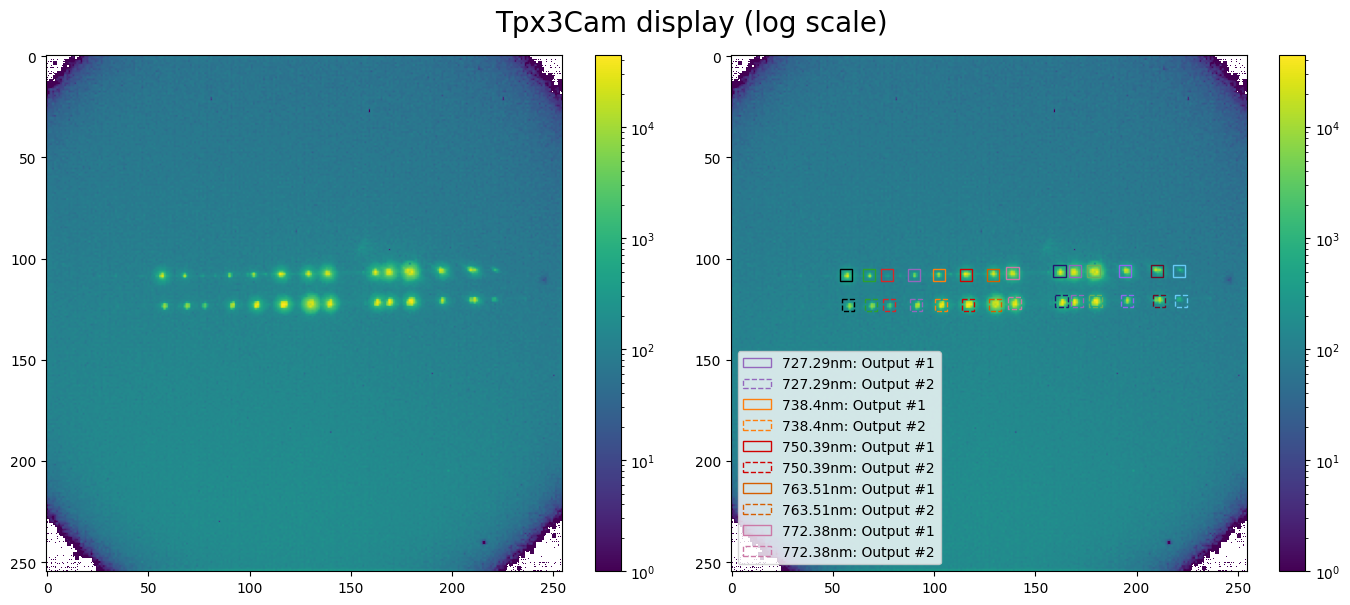

In [12]:
#remaking the next code block to make it work for me

hist, xedges, yedges = np.histogram2d(MZI_df_preview['#Col'], MZI_df_preview['#Row'], bins=[255, 255])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Tpx3Cam display (log scale)", fontsize=20)

im1 = ax1.imshow(hist, origin='upper', norm=matplotlib.colors.LogNorm())
colorbar1 = fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(hist, origin='upper', norm=matplotlib.colors.LogNorm())

for i, spot in spot_df.iterrows():
    if abs(spot['wavelength(nm)'] - 750) < 33.0:
        label = f"{spot['wavelength(nm)']}nm: Output #{spot['#output']}"
    else:
        label = None
    if spot['#output'] == 1:
        line_style = 'solid'
    elif spot['#output'] == 2:
        line_style = 'dashed'
    spot_patch = matplotlib.patches.Rectangle((spot['y_start'], spot['x_start']), spot['y_extent'], spot['x_extent'],
                    linewidth=1, edgecolor=spot['display_color'], facecolor='none', label=label, ls=line_style)
    ax2.add_patch(spot_patch)

colorbar2 = fig.colorbar(im2, ax=ax2)
ax2.legend()

#plt.subplots_adjust(wspace=0.2)
fig.tight_layout()
plt.show()

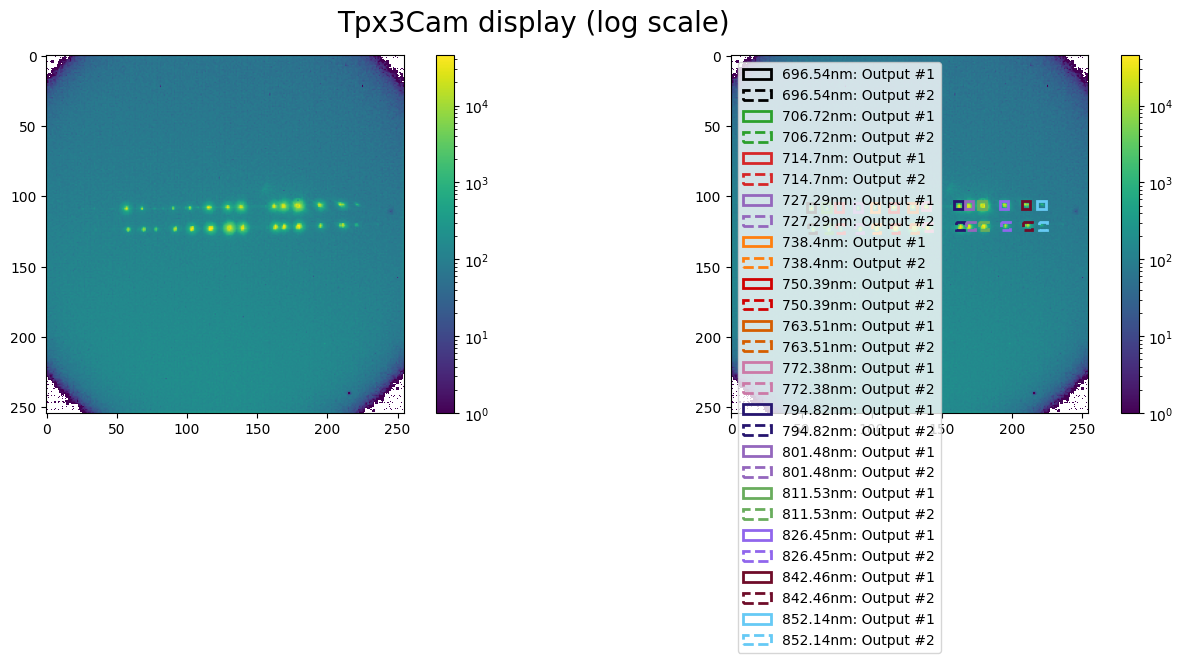

In [13]:
hist, xedges, yedges = np.histogram2d(MZI_df_preview['#Col'], MZI_df_preview['#Row'], bins=[255, 255])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Tpx3Cam display (log scale)", fontsize=20)

plt.subplot(121)
im1 = plt.imshow(hist, origin='upper', norm=matplotlib.colors.LogNorm())
colorbar1 = plt.colorbar(im1)

plt.subplot(122)
im2 = plt.imshow(hist, origin='upper', norm=matplotlib.colors.LogNorm())


for i, spot in spot_df.iterrows():
    label = f"{spot['wavelength(nm)']}nm: Output #{spot['#output']}"
    if spot['#output'] == 1:
        line_style = 'solid'
    elif spot['#output'] == 2:
        line_style = 'dashed'
    spot_patch = matplotlib.patches.Rectangle((spot['y_start'], spot['x_start']), spot['y_extent'], spot['x_extent'],
                    linewidth=2, edgecolor=spot['display_color'], facecolor='none', label=label, ls=line_style)
    ax2.add_patch(spot_patch)

colorbar2 = plt.colorbar(im2)
ax2.legend()

#plt.subplots_adjust(wspace=0.2)
fig.tight_layout()
plt.show()

### In the figure above spots are longer in wavelength the FURTHER RIGHT they are

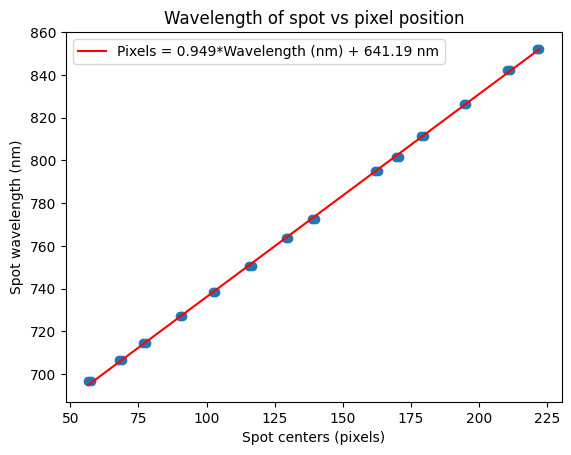

This spectrometer currently has a spectral resolution of 0.949 nm/pixel (1.053 pixel/nm)
This means with 255 total pixels a width of 242.11 nm can be fit on the detector, ranging from 641.19 nm - 883.30 nm.


In [14]:
#to accept an x-displacement between patterns, we should really have two graphs, one for each bar.
spot_middle = (spot_df['y_start'] + spot_df['y_end']) / 2
plt.scatter(spot_middle, spot_df['wavelength(nm)'])

# Linear fitting
coefficients = np.polyfit(spot_middle, spot_df['wavelength(nm)'], 1)
m, b = coefficients
wavelength_linspace = np.linspace(min(spot_middle), max(spot_middle), 100)
pixel_vals = m * wavelength_linspace + b

plt.plot(wavelength_linspace, pixel_vals, color='red', label=f'Pixels = {m:.3f}*Wavelength (nm) + {b:.2f} nm')

plt.xlabel("Spot centers (pixels)")
plt.ylabel("Spot wavelength (nm)")
plt.title("Wavelength of spot vs pixel position")
plt.legend()
plt.show()



wavelength_per_pixel = m
print(f"This spectrometer currently has a spectral resolution of {wavelength_per_pixel:.3f} nm/pixel ({wavelength_per_pixel**-1:.3f} pixel/nm)")
print(f"This means with 255 total pixels a width of {wavelength_per_pixel*255:.2f} nm can be fit on the detector, ranging from {b:.2f} nm - {b+wavelength_per_pixel*255:.2f} nm.")

# Binning timestamps within regions into separate histograms (similar to data reading of SPADs)

### The code below should only need to be run one time when data is first collected, .pkl files should be created after to store all histograms to avoid this time consuming process again

In [15]:
chunk_size = 10000000 # Defines how many entries of the csv will be read into memory at one time

# Adding column named hist_vals filled with np.zeros(nbins)
hist_vals = [np.zeros(nbins) for _ in range(spot_df.shape[0])]

with pd.read_csv(cent_csv, usecols=['#Col', '#Row', '#ToA'], chunksize=chunk_size) as reader:
    for chunk in reader:
        # Extract timestamps within specified regions defined above within the current chunk of the file
        for i, spot in spot_df.iterrows():
            spot_timestamps = chunk[
                (spot['x_start'] <= chunk['#Row']) & (chunk['#Row'] <= spot['x_end']) &
                (spot['y_start'] <= chunk['#Col']) & (chunk['#Col'] <= spot['y_end'])]['#ToA']
            
            # Aggregating all timestamps for spot within corresponding hist_vals list
            hist_vals[i] += np.histogram(spot_timestamps, bins=hist_bins)[0]
            
        # Creating display for where you are in file
        last_timestamp = chunk.iloc[-1]
        rt = last_timestamp['#ToA'] * total_time / (end_time - start_time)
        
        clear_output(wait=True)
        print(f"Current position in csv: {rt} {time_div_label}")
        
spot_df['hist_vals'] = hist_vals
spot_df

Current position in csv: 20.01604088928272 min


wavelength(nm)  #output  x_start  x_end  x_extent  y_start  y_end  \
0           696.54        1    105.0  111.0         6     53.6   59.6   
1           696.54        2    120.0  126.0         6     54.6   60.6   
2           706.72        1    105.0  111.0         6     64.8   70.8   
3           706.72        2    120.0  126.0         6     65.8   71.8   
4           714.70        1    105.0  111.0         6     73.6   79.6   
5           714.70        2    120.0  126.0         6     74.6   80.6   
6           727.29        1    105.0  111.0         6     87.1   93.1   
7           727.29        2    120.0  126.0         6     88.1   94.1   
8           738.40        1    105.0  111.0         6     99.2  105.2   
9           738.40        2    120.0  126.0         6    100.2  106.2   
10          750.39        1    105.0  111.0         6    112.7  118.7   
11          750.39        2    120.0  126.0         6    113.7  119.7   
12          763.51        1    105.0  111.0         6    126.0  132.0   
13          763.51        2    120.0  126.0         6    127.0  133.0   
14          772.38        1    104.0  110.0         6    135.7  141.7   
15          772.38        2    119.0  125.0         6    136.7  142.7   
16          794.82        1    103.0  109.0         6    158.9  164.9   
17          794.82        2    118.0  124.0         6    159.9  165.9   
18          801.48        1    103.0  109.0         6    166.5  172.5   
19          801.48        2    118.0  124.0         6    167.5  173.5   
20          811.53        1    103.0  109.0         6    175.7  181.7   
21          811.53        2    118.0  124.0         6    176.7  182.7   
22          826.45        1    103.0  109.0         6    191.3  197.3   
23          826.45        2    118.0  124.0         6    192.3  198.3   
24          842.46        1    103.0  109.0         6    207.1  213.1   
25          842.46        2    118.0  124.0         6    208.1  214.1   
26          852.14        1    103.0  109.0         6    218.0  224.0   
27          852.14        2    118.0  124.0         6    219.0  225.0   

    y_extent display_color                                          hist_vals  
0          6       #000000  [550.0, 588.0, 524.0, 574.0, 529.0, 534.0, 520...  
1          6       #000000  [543.0, 601.0, 511.0, 493.0, 521.0, 524.0, 557...  
2          6       #2ca02c  [551.0, 640.0, 545.0, 584.0, 573.0, 565.0, 565...  
3          6       #2ca02c  [543.0, 694.0, 580.0, 537.0, 546.0, 537.0, 588...  
4          6       #d62728  [560.0, 654.0, 596.0, 600.0, 614.0, 620.0, 623...  
5          6       #d62728  [565.0, 710.0, 652.0, 604.0, 618.0, 626.0, 590...  
6          6       #9467bd  [645.0, 753.0, 649.0, 643.0, 709.0, 684.0, 696...  
7          6       #9467bd  [720.0, 848.0, 683.0, 671.0, 645.0, 703.0, 748...  
8          6       #ff7f0e  [751.0, 874.0, 736.0, 720.0, 765.0, 815.0, 783...  
9          6       #ff7f0e  [914.0, 1033.0, 952.0, 933.0, 910.0, 933.0, 92...  
10         6       #D00101  [879.0, 1027.0, 900.0, 909.0, 867.0, 857.0, 87...  
11         6       #D00101  [1052.0, 1178.0, 1049.0, 1033.0, 992.0, 1095.0...  
12         6       #D55E00  [1252.0, 1402.0, 1210.0, 1191.0, 1236.0, 1275....  
13         6       #D55E00  [1232.0, 1382.0, 1228.0, 1164.0, 1209.0, 1217....  
14         6       #CC79A7  [921.0, 1020.0, 922.0, 890.0, 859.0, 946.0, 88...  
15         6       #CC79A7  [878.0, 1053.0, 888.0, 898.0, 941.0, 889.0, 91...  
16         6       #26156F  [936.0, 1116.0, 960.0, 950.0, 974.0, 993.0, 96...  
17         6       #26156F  [934.0, 1103.0, 1026.0, 965.0, 980.0, 977.0, 9...  
18         6       #9467bd  [1071.0, 1134.0, 978.0, 1034.0, 1042.0, 1047.0...  
19         6       #9467bd  [985.0, 1130.0, 1020.0, 1026.0, 1018.0, 1057.0...  
20         6       #69AD5D  [1070.0, 1144.0, 1088.0, 1098.0, 1089.0, 1110....  
21         6       #69AD5D  [1043.0, 1190.0, 1082.0, 1080.0, 1041.0, 1074....  
22         6       #9066ed  [1119.0, 1262.0, 1

In [16]:
# Saving histograms to pickle files to not have to go through process of aggregation again
#to change the file name to save data for multiple measurements,
for i, spot in spot_df.iterrows():
    file_name = f"hist_GaAs_20min_realign_cent_{spot['wavelength(nm)']}_{spot['#output']}.pkl"
    with open(file_name, 'wb') as f:
        pickle.dump(spot_df.loc[i, 'hist_vals'], f)

## Animation of data collection (Optional: use for troubleshooting, presentation, or fun :D) Currently does not animate over full csv for some unknown reason :(

In [1]:

chunk_size = 1000000 # Defines how many entries of the csv will be displayed at one time

# Initializing plot to be updated
fig, ax = plt.subplots(figsize=(8, 6))
hist, xedges, yedges = np.histogram2d(MZI_df_preview['#Col'], MZI_df_preview['#Row'], bins=255)

im = plt.imshow(hist, origin='upper', norm=matplotlib.colors.LogNorm())
colorbar = plt.colorbar(im)
ax.set_title(f'Experiment Time: 0.00 {time_div_label}')

def animate(chunk):
    last_timestamp = chunk.iloc[-1]
    rt = last_timestamp['#ToA'] * total_time / (end_time - start_time)
    hist, xedges, yedges = np.histogram2d(chunk['#Col'], chunk['#Row'], bins=255)
    im.set_data(hist)
    ax.set_title(f'Experiment Time: {rt:.2f} {time_div_label}')
    
    clear_output(wait=True)
    print(f"Current frame: {rt} {time_div_label}")

def chunk_generator():
    with pd.read_csv(cent_csv, usecols=['#Col', '#Row', '#ToA'], chunksize=chunk_size) as reader:
        for chunk in reader:
            yield chunk
            
animation = FuncAnimation(fig, animate, frames=chunk_generator, blit=False)
plt.close()

#my computer doesn't know what mp4s are apparently
#animation = FuncAnimation(fig, animate, frames=chunk_generator, blit=False)
#plt.close()

animation_file = "MZI_animation.gif"  # Specify the desired location here
animation.save(animation_file)

# Display a message indicating where the animation file is saved
print("Animation saved as:", animation_file)

NameError: name 'plt' is not defined

# Graphing created histograms

In [15]:
# Loading previously made hist_val files into current notebook kernel
hist_vals = []
for i, spot in spot_df.iterrows():
    file_name = f"hist_GaAs_20min_realign_cent_{spot['wavelength(nm)']}_{spot['#output']}.pkl"
    with open(file_name, 'rb') as f:
        hist_vals.append(pickle.load(f))
        
spot_df['hist_vals'] = hist_vals

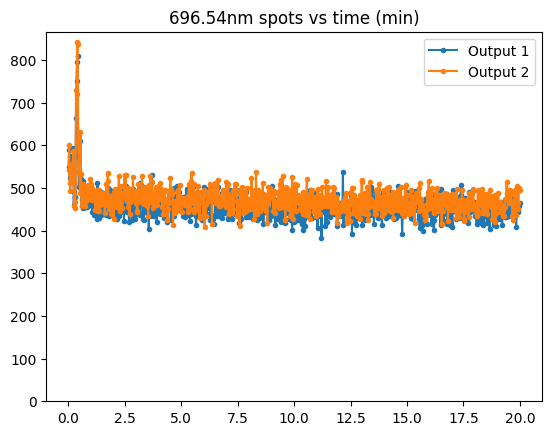

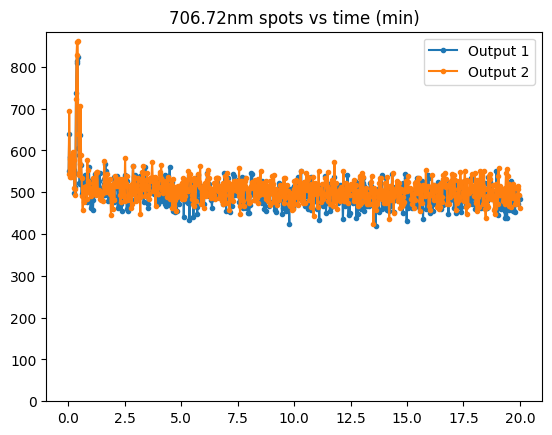

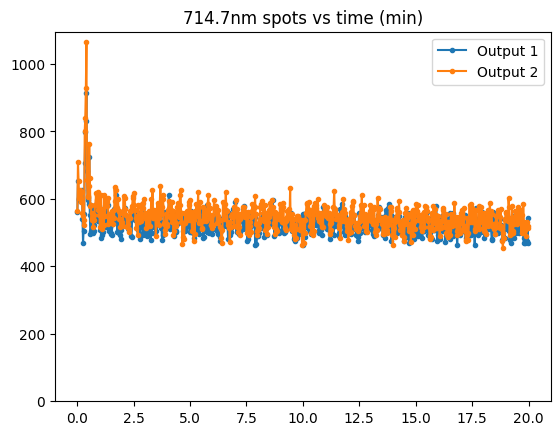

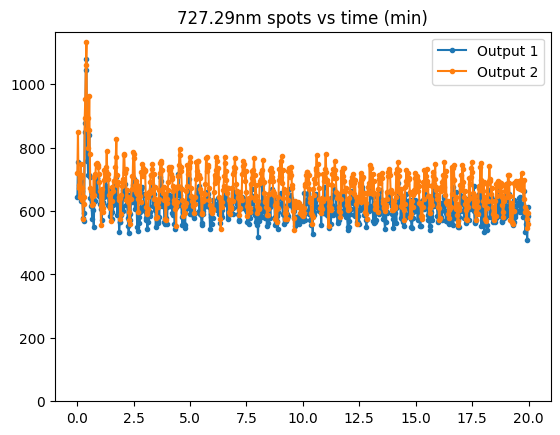

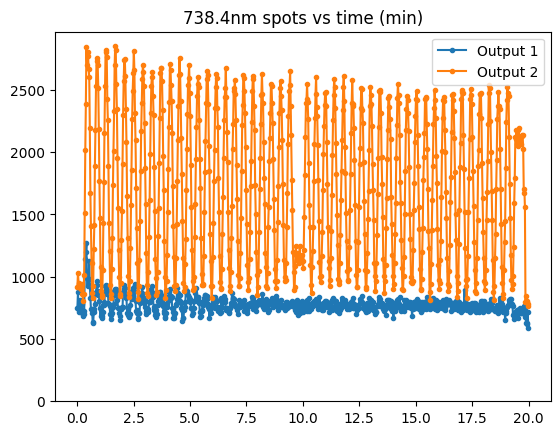

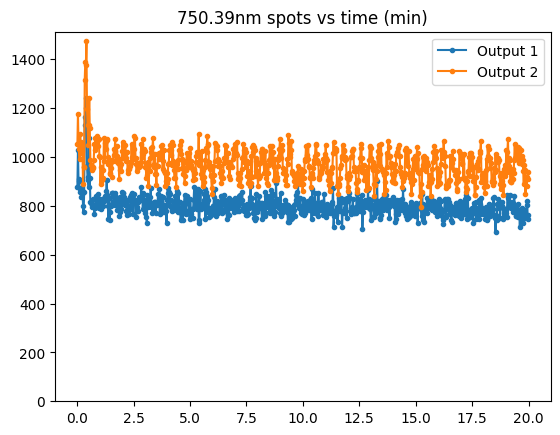

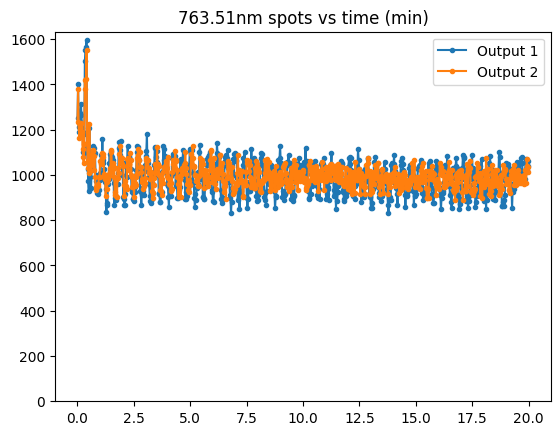

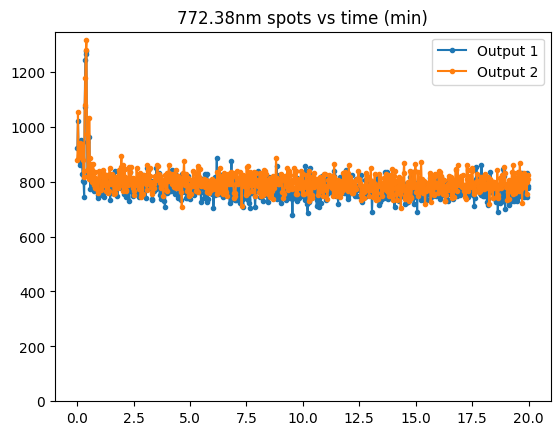

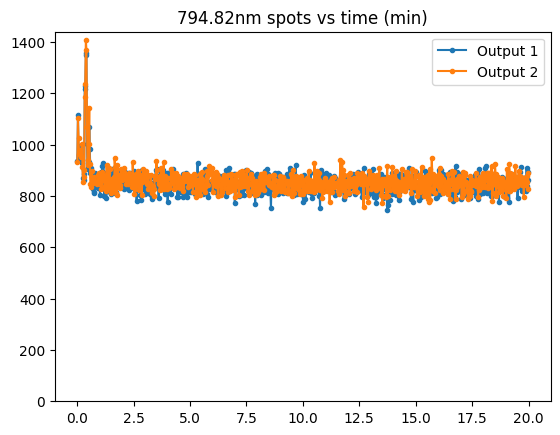

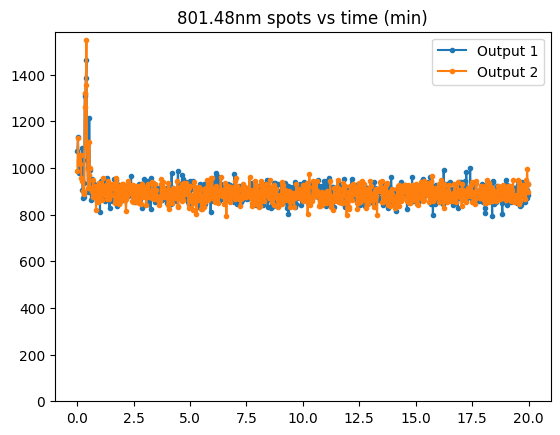

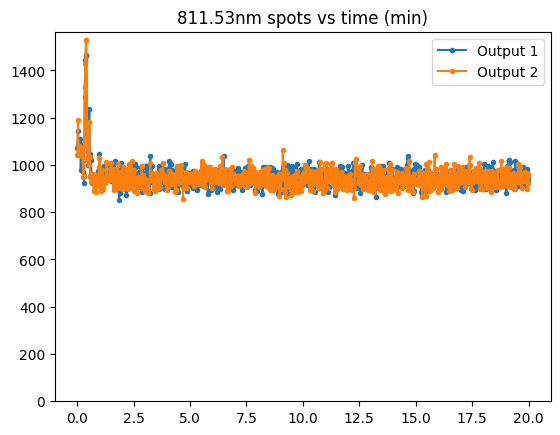

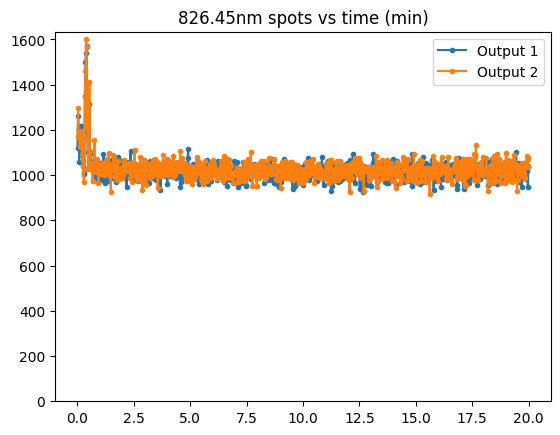

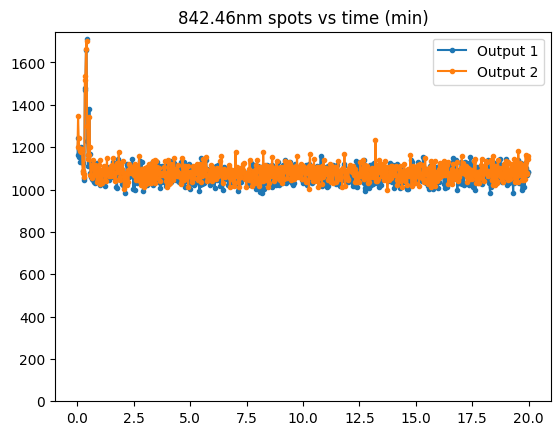

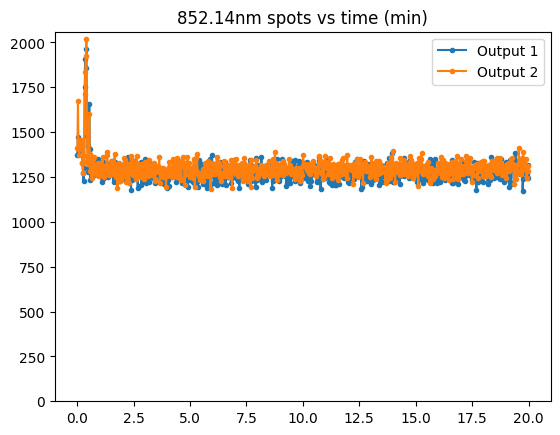

In [16]:
for i, spot in spot_df.iloc[::2].iterrows():
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]
    
    plt.plot(bin_centers_rt, output_1['hist_vals'], marker='.', label=f"Output {output_1['#output']}")
    plt.plot(bin_centers_rt, output_2['hist_vals'], marker='.', label=f"Output {output_2['#output']}")

    plt.ylim(bottom=0)
    
    plt.title(f"{spot['wavelength(nm)']}nm spots vs time ({time_div_label})")
    plt.legend()
    plt.show()

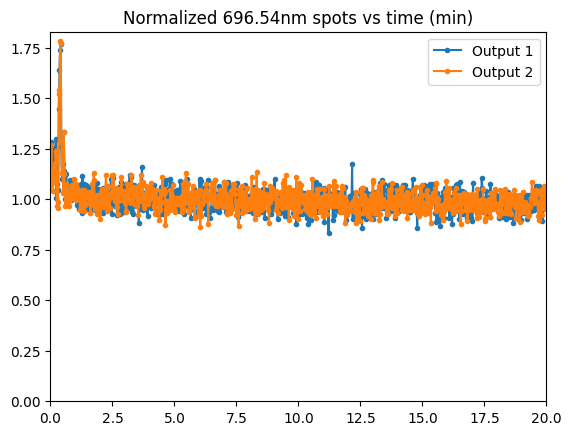

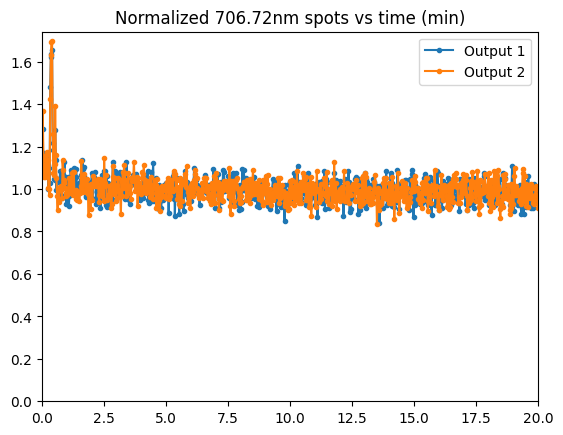

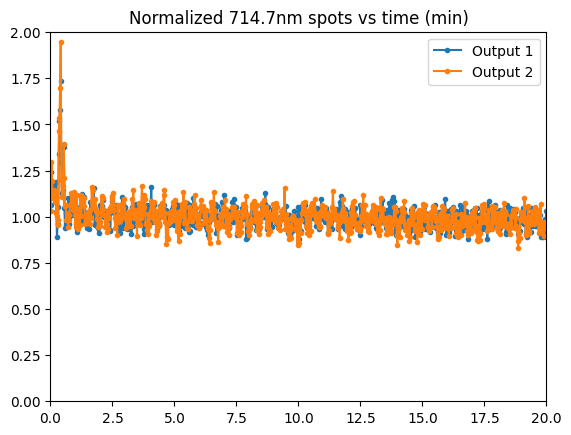

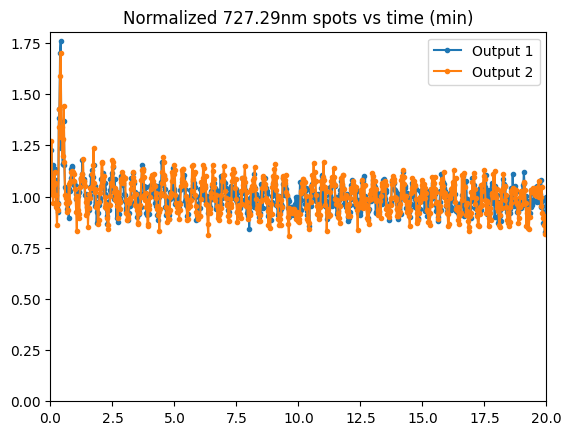

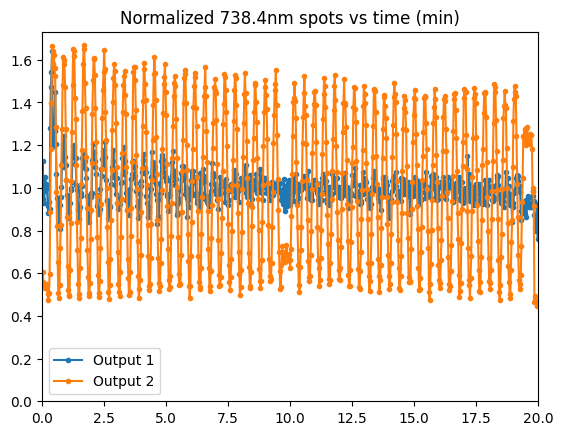

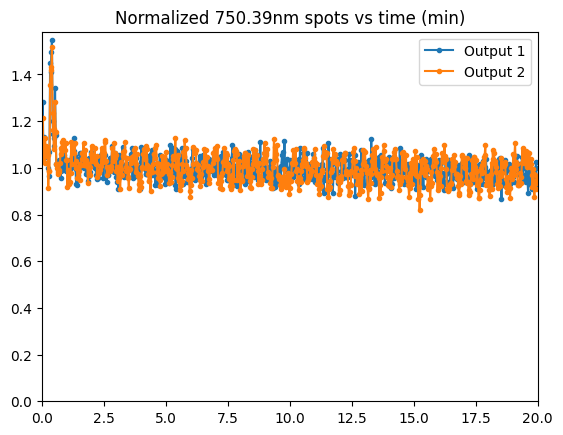

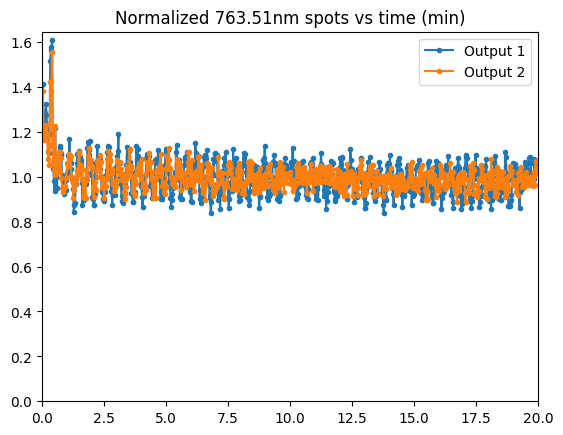

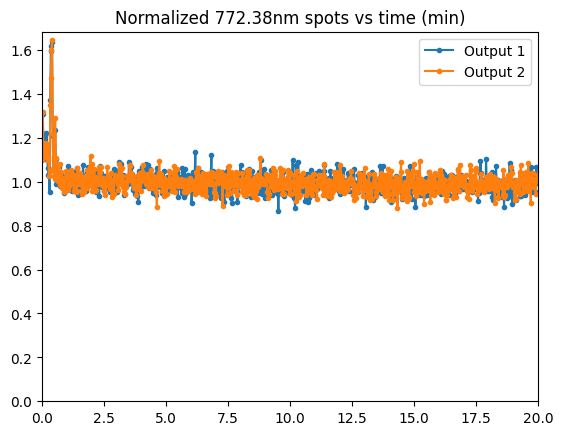

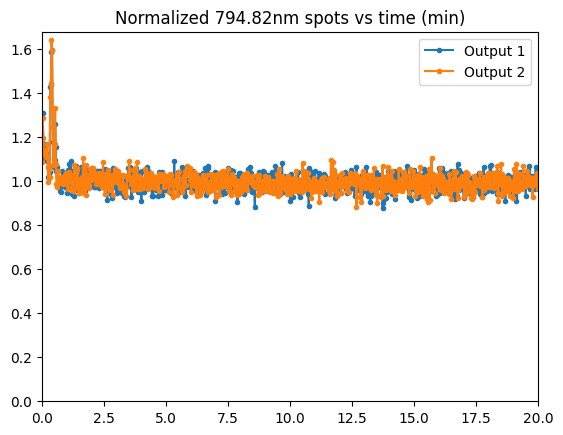

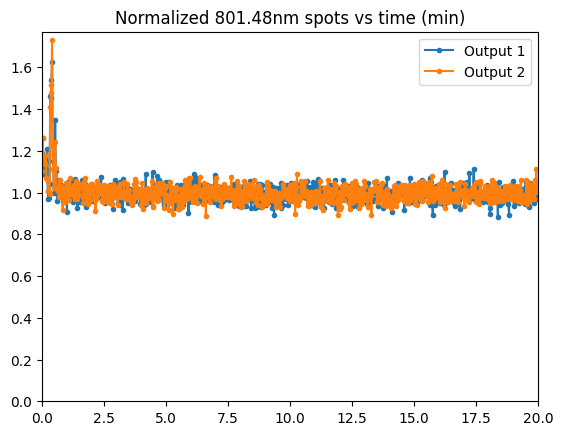

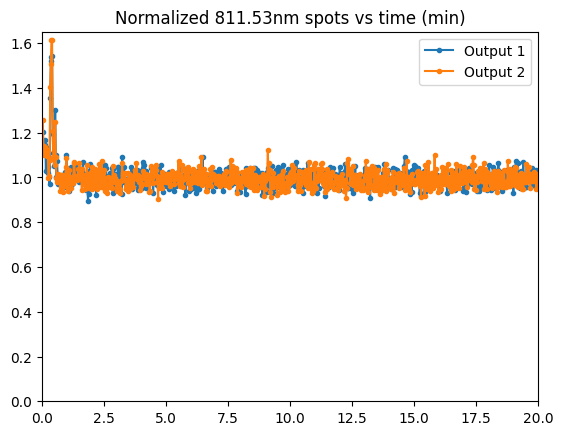

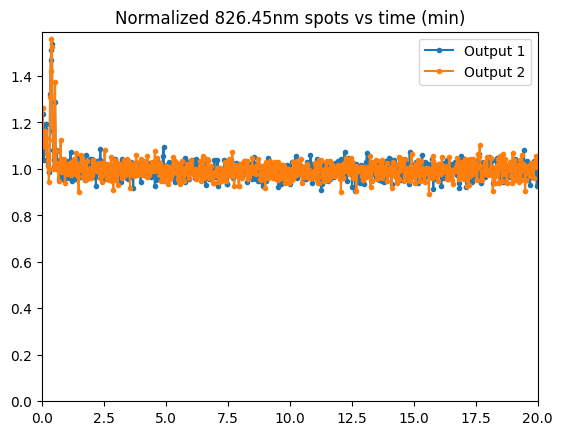

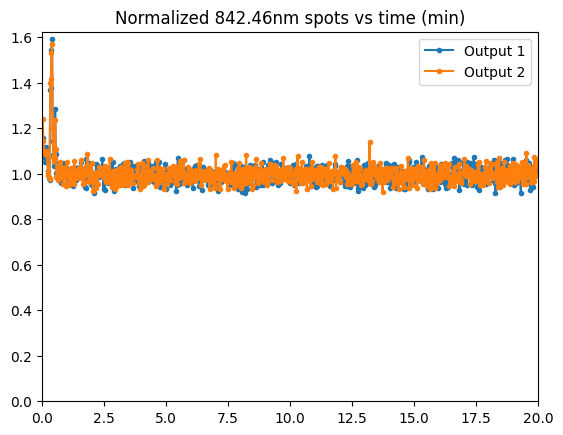

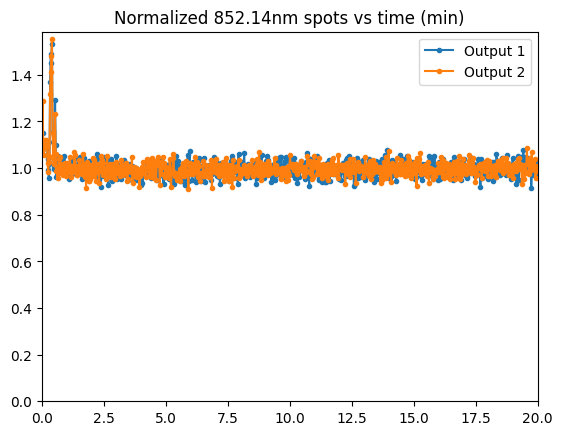

In [17]:
for i, spot in spot_df.iloc[::2].iterrows():
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]
    
    plt.plot(bin_centers_rt, output_1['hist_vals'] / np.average(output_1['hist_vals']), marker='.', 
             label=f"Output {output_1['#output']}")
    plt.plot(bin_centers_rt, output_2['hist_vals'] / np.average(output_2['hist_vals']), marker='.', 
             label=f"Output {output_2['#output']}")

    plt.ylim(bottom=0)
    plt.xlim(0, 20)
    
    plt.title(f"Normalized {spot['wavelength(nm)']}nm spots vs time ({time_div_label})")
    plt.legend()
    plt.show()

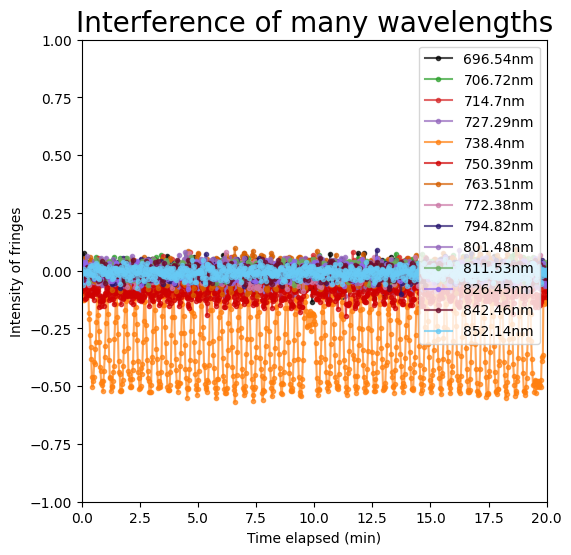

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
visibility_vals = []

for i, spot in spot_df.iloc[::2].iterrows():
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]
    
    spot_visibility = (output_1['hist_vals'] - output_2['hist_vals']) / (output_1['hist_vals'] + output_2['hist_vals'])
    visibility_vals.append(spot_visibility)
    visibility_vals.append(-spot_visibility) # Outputs 1 and 2 will get opposite visibility values
    
    plt.plot(bin_centers_rt, spot_visibility, marker='.', color=spot_df.loc[i, 'display_color'], 
             label=f"{spot['wavelength(nm)']}nm", alpha=0.7)

spot_df['vis_vals'] = visibility_vals
    
plt.ylim(-1, 1)
plt.xlim(0, 20)
plt.xlabel(f"Time elapsed ({time_div_label})")
plt.ylabel("Intensity of fringes")
plt.title(f"Interference of many wavelengths", fontsize=20)
plt.legend()
plt.show()

# Fourier analysis

## Functions used for finding theoretical interference pattern frequencies

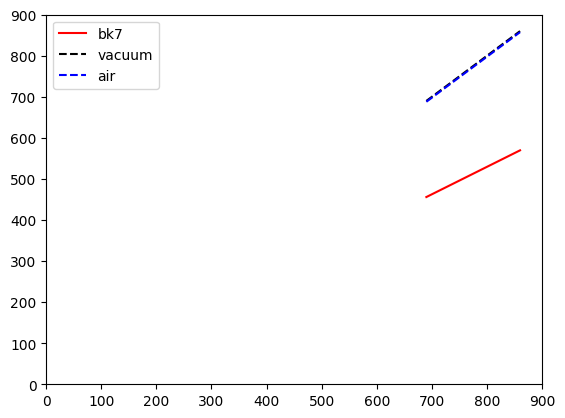

In [19]:
# https://en.wikipedia.org/wiki/Sellmeier_equation
def sellemeier_bk7(wavelength): # Measured in nm
    return np.sqrt(1 + 1.03961212*wavelength**2/(wavelength**2-6.00069867e3) + 0.231792344*wavelength**2/(wavelength**2-2.00179144e4) + 1.01046945*wavelength**2/(wavelength**2-1.03560653e8))

fig, ax = plt.subplots()
x = np.linspace(690,860,1000)
ax.plot(x,x/sellemeier_bk7(x),'r-',label='bk7')
ax.plot(x,x,'k--',label='vacuum')
ax.plot(x,x/1.003,'b--',label='air')
ax.set_xlim(0,900)
ax.set_ylim(0,900)
ax.legend()

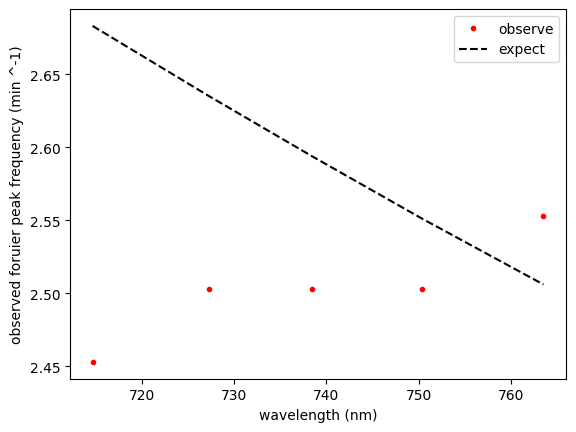

In [81]:
fig, ax = plt.subplots()
x = [714.7, 727.29, 738.4, 750.39, 763.51]
ax.plot(x,[2.453,2.503,2.503,2.503,2.553],'r.',label='observe')
ax.plot(x,[2.683,2.635,2.594,2.551,2.506],'k--',label='expect')
ax.set_xlabel('wavelength (nm)')
ax.set_ylabel('observed foruier peak frequency (min ^-1)')
ax.legend()

In [20]:
# Only works if motor code is still giving a steps command of value 32 
# (32 steps corresponds to a motor movement of 2.5 microns, scale the 2.5 in the fxn below to the correct value if needed)
# Returns in inverse units of time divisions being used for display units
def find_int_freq(wavelength, motorMovementsPerExposure=motorMovementsPerExposure, exposure_time=exposure_time, time_div_val=time_div_val):
    return(1000*2.5*motorMovementsPerExposure*np.tan(np.radians(1))*(sellemeier_bk7(wavelength)-1) / (wavelength*exposure_time)) * time_div_val

In [21]:
find_int_freq(785)

np.float64(2.4351939005345704)

## Defining limits on what gets fourier analyzed

In [22]:
# Times you want the modeling to start and end at (measured in minutes, seconds, etc.)
model_start = 0.0
model_end = 20.0

In [23]:
# Finding closest index in bin_centers_rt array to above values
start_index = np.argmin(np.abs(bin_centers_rt-model_start))
end_index = np.argmin(np.abs(bin_centers_rt-model_end))
model_size = end_index - start_index

print(f"The model will start at index {start_index} and end at {end_index} within the value arrays.")

The model will start at index 0 and end at 799 within the value arrays.


In [24]:
# Creating fft values using np.fft.fft
frequencies = np.fft.fftfreq(model_size, bin_centers_rt[1] - bin_centers_rt[0])
fft_vals = []
fft_vis_vals = []

for i, spot in spot_df.iterrows():
    spot_fft = np.fft.fft(spot['hist_vals'][start_index:end_index])
    fft_vals.append(spot_fft)
    
    if i % 2 == 0:
        visibility_fft = np.fft.fft(spot['vis_vals'][start_index:end_index])
        fft_vis_vals.append(visibility_fft)
        fft_vis_vals.append(visibility_fft)
        
spot_df['fft_vals'] = fft_vals
spot_df['fft_vis_vals'] = fft_vis_vals

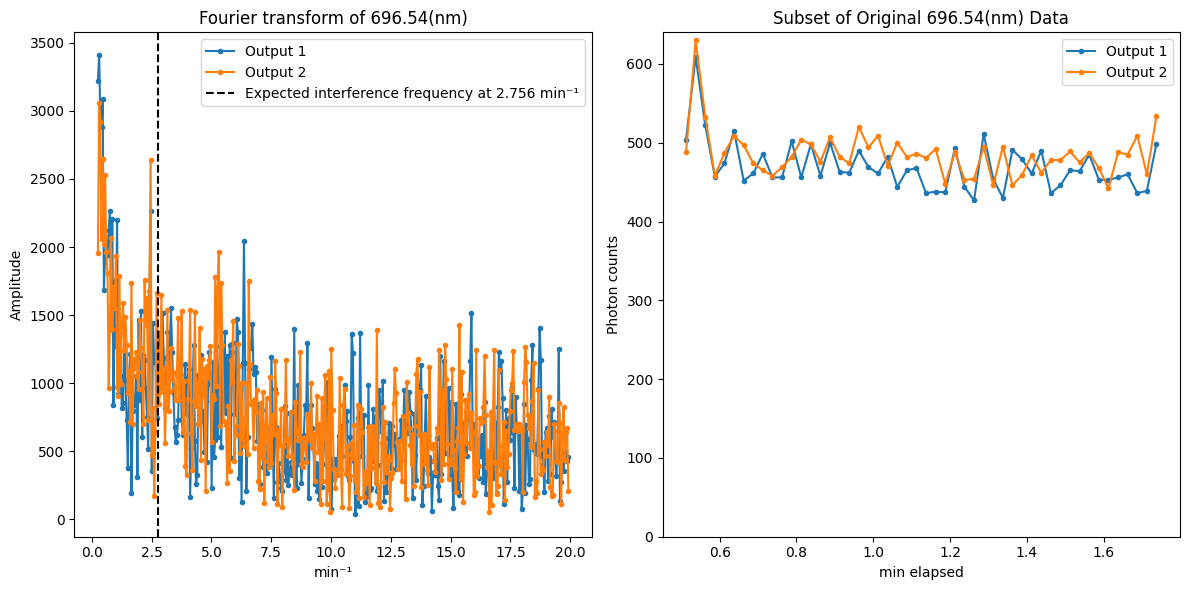

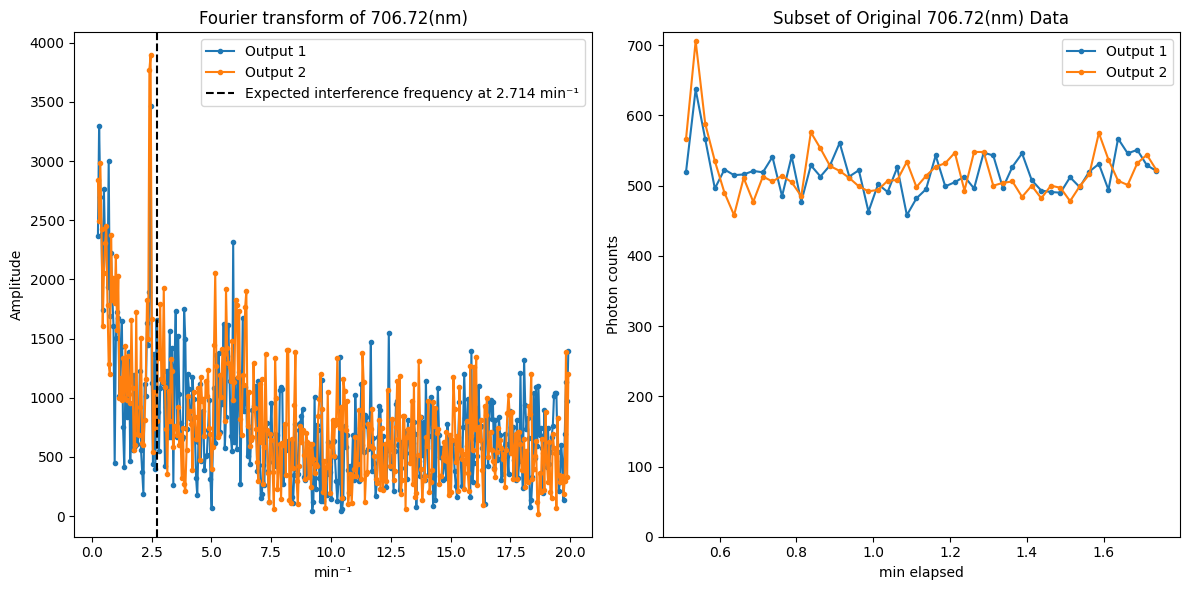

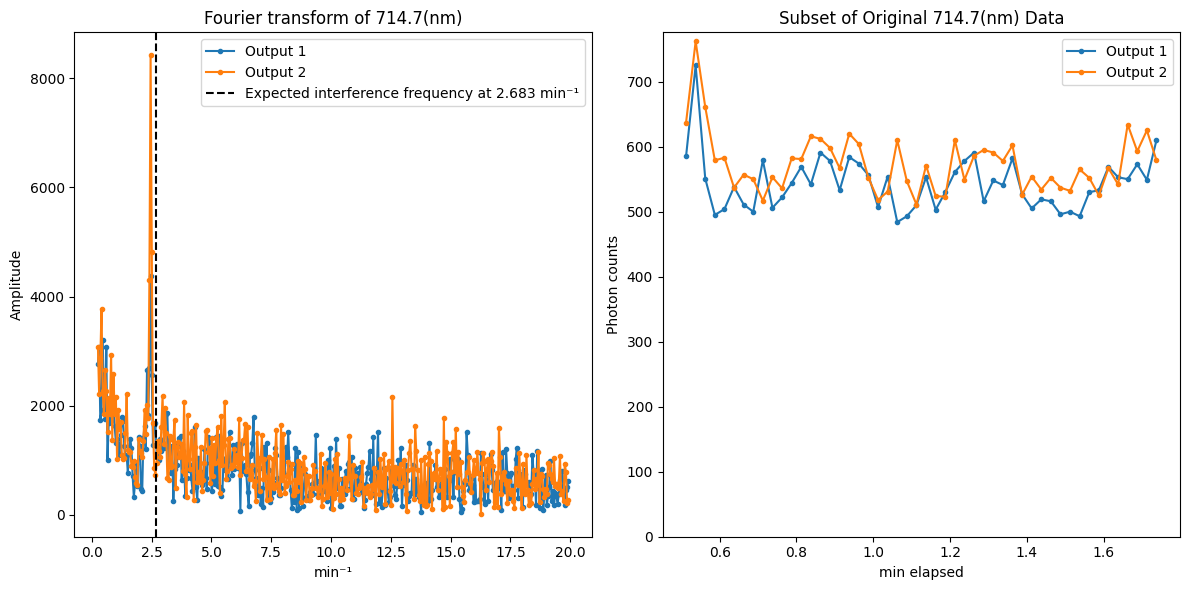

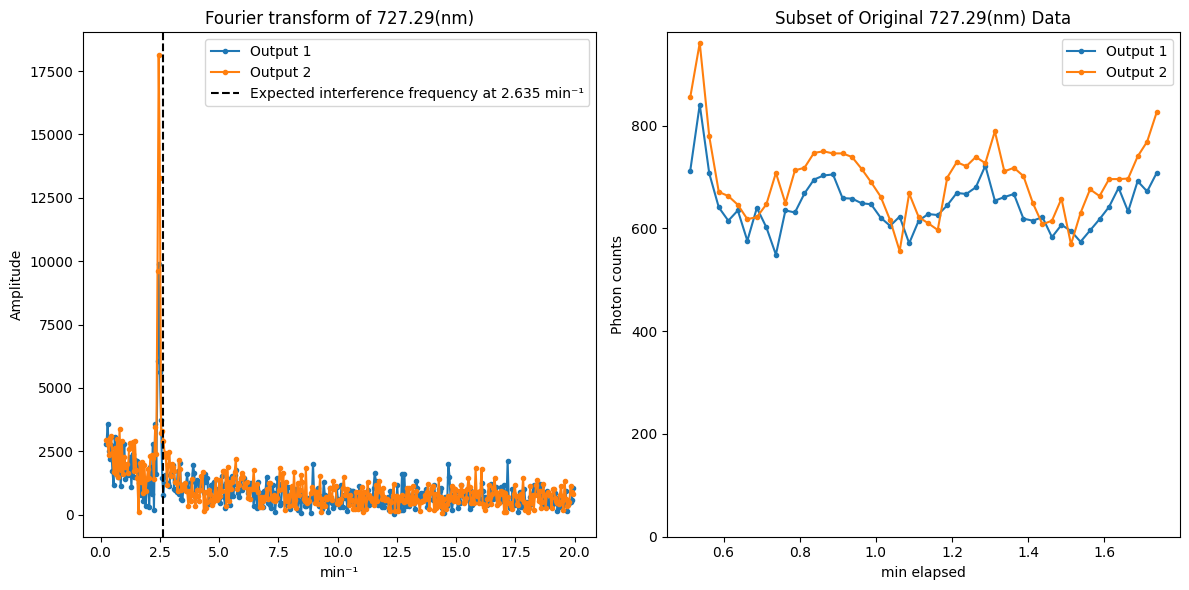

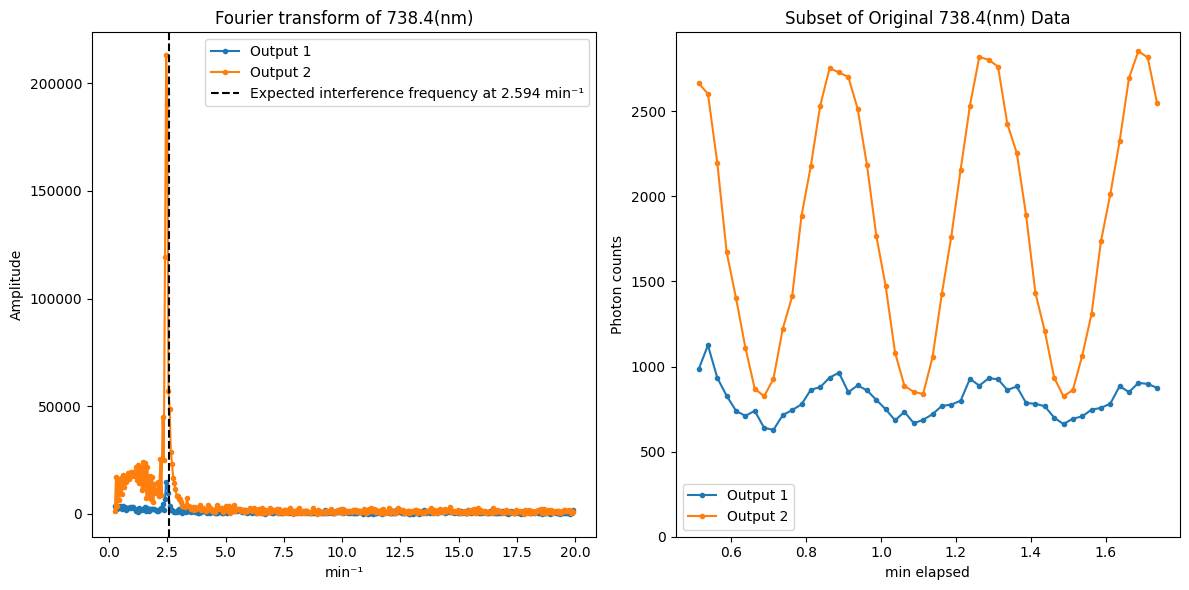

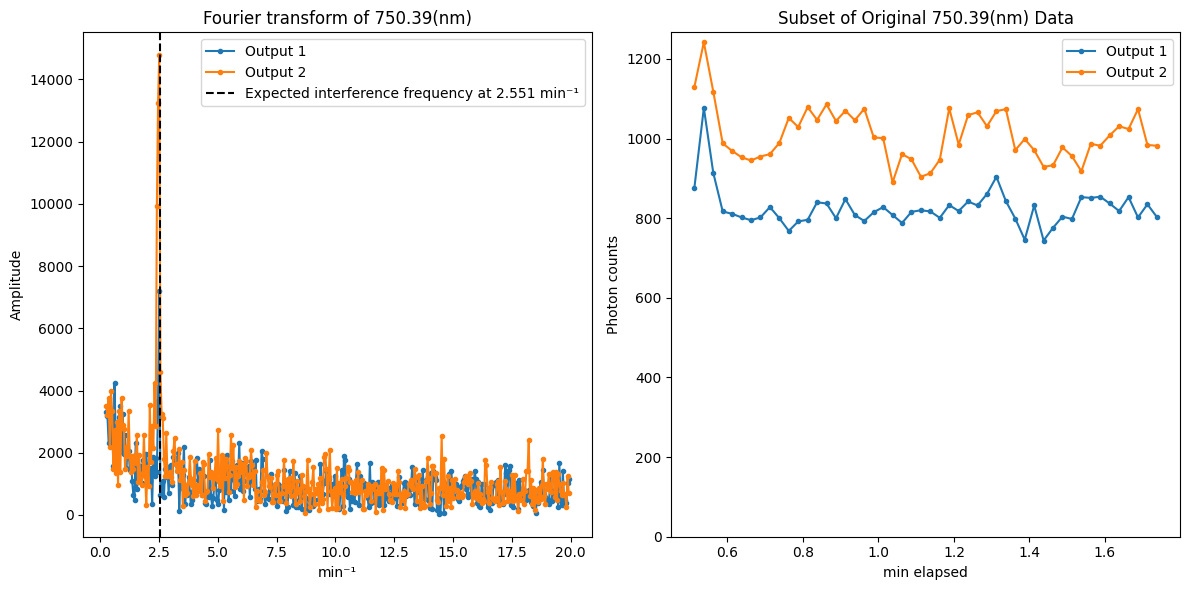

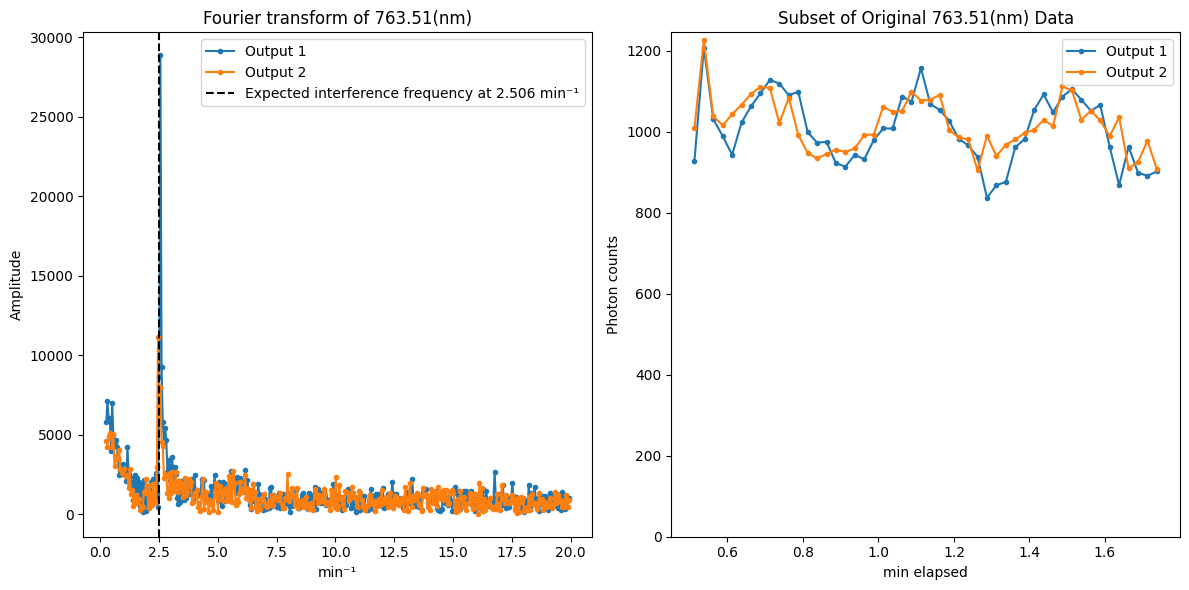

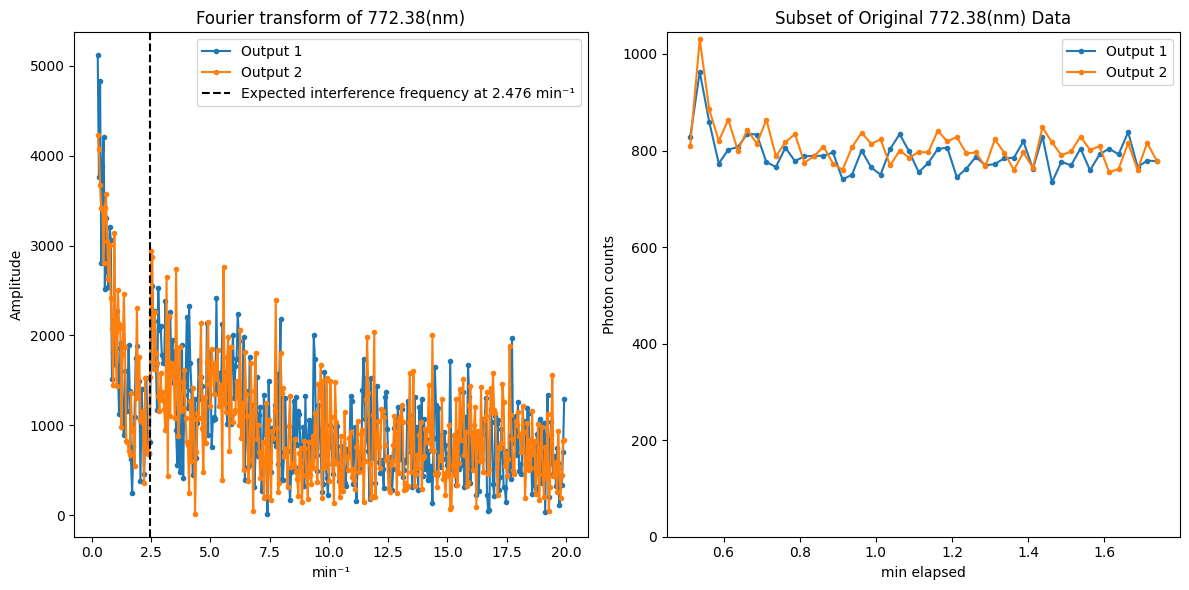

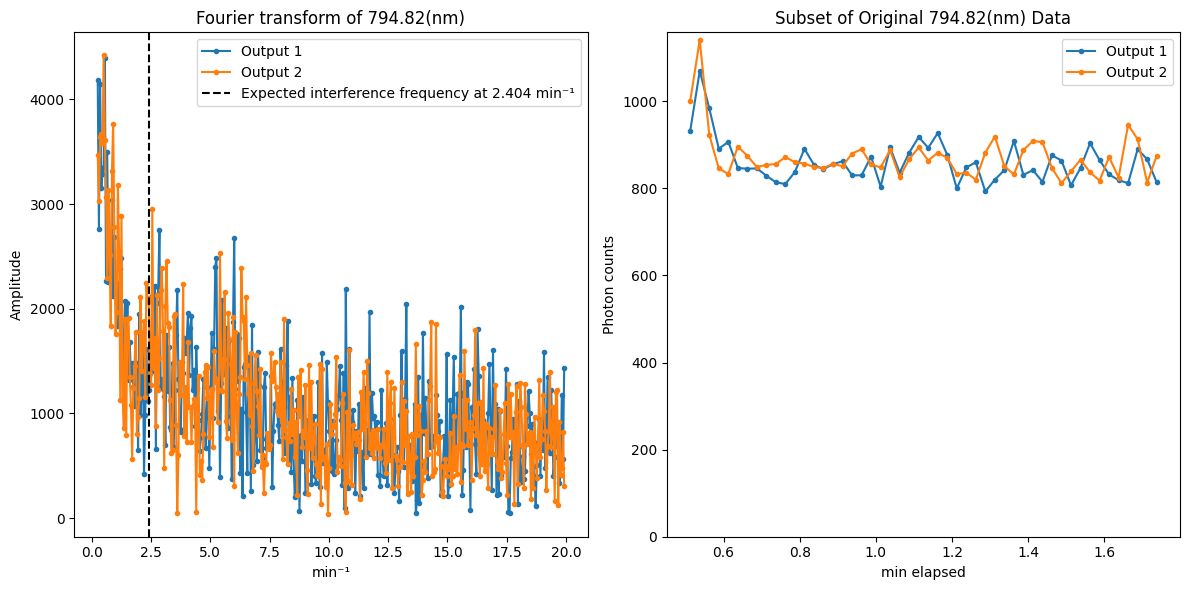

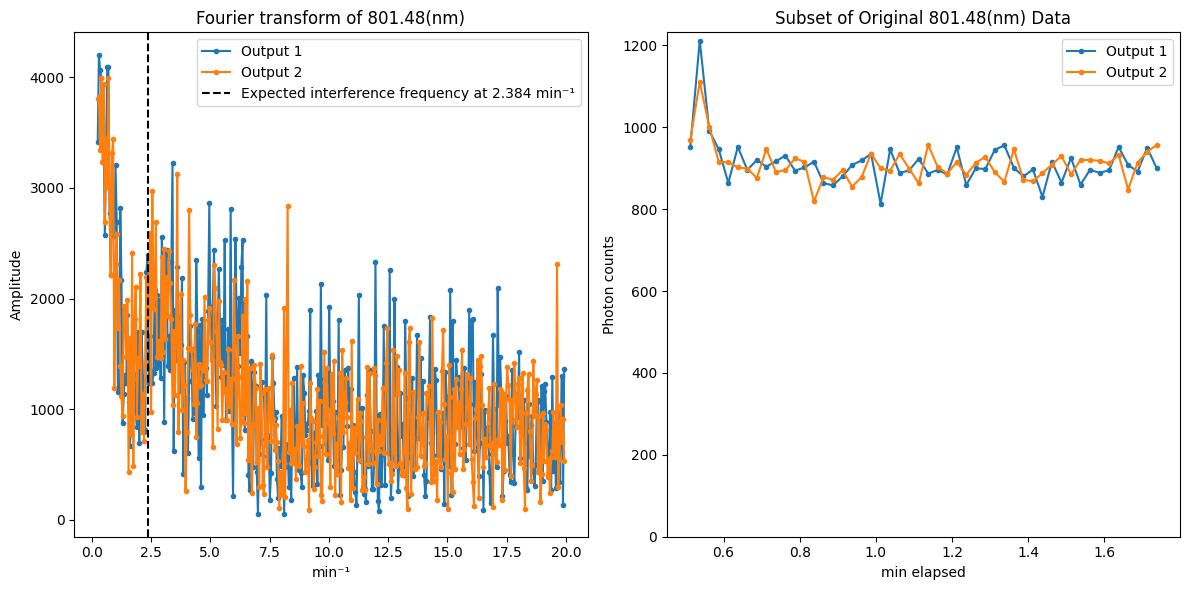

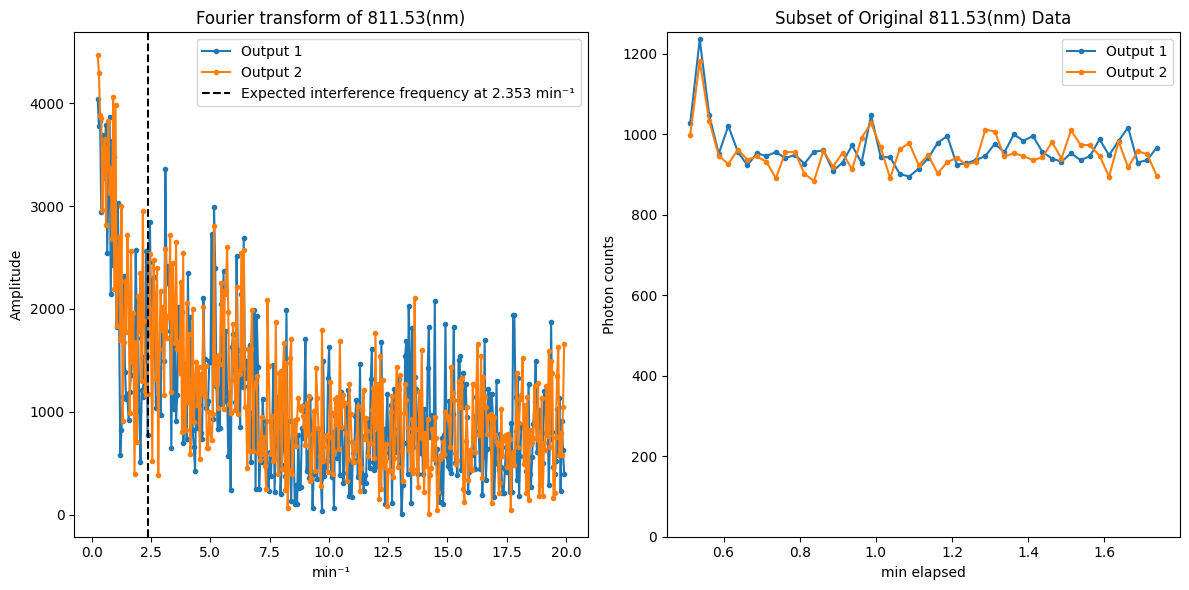

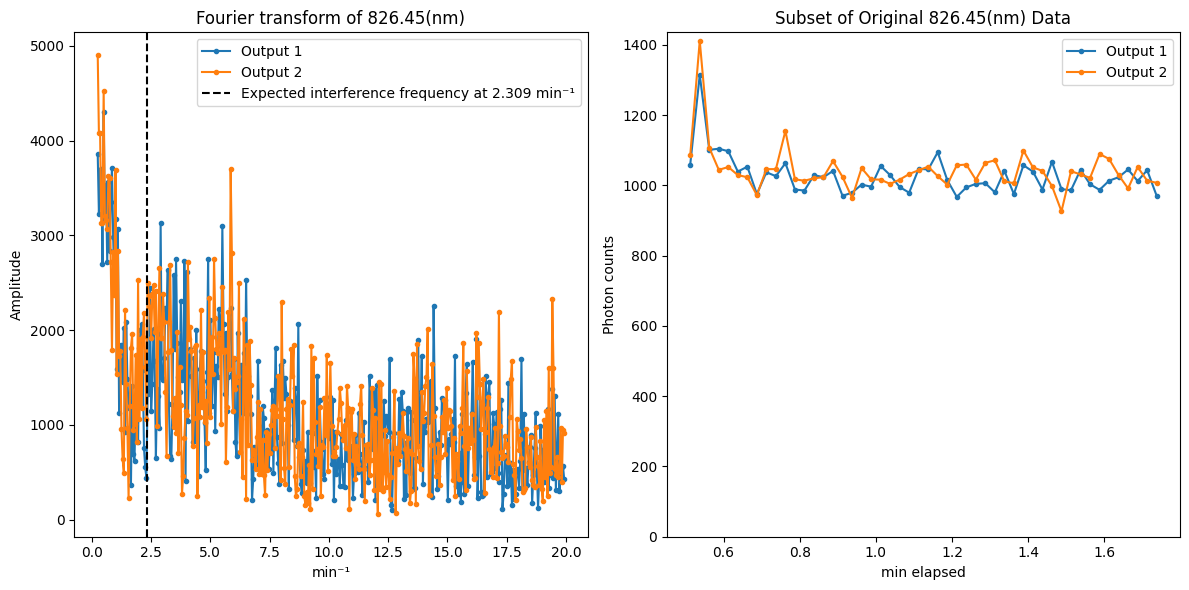

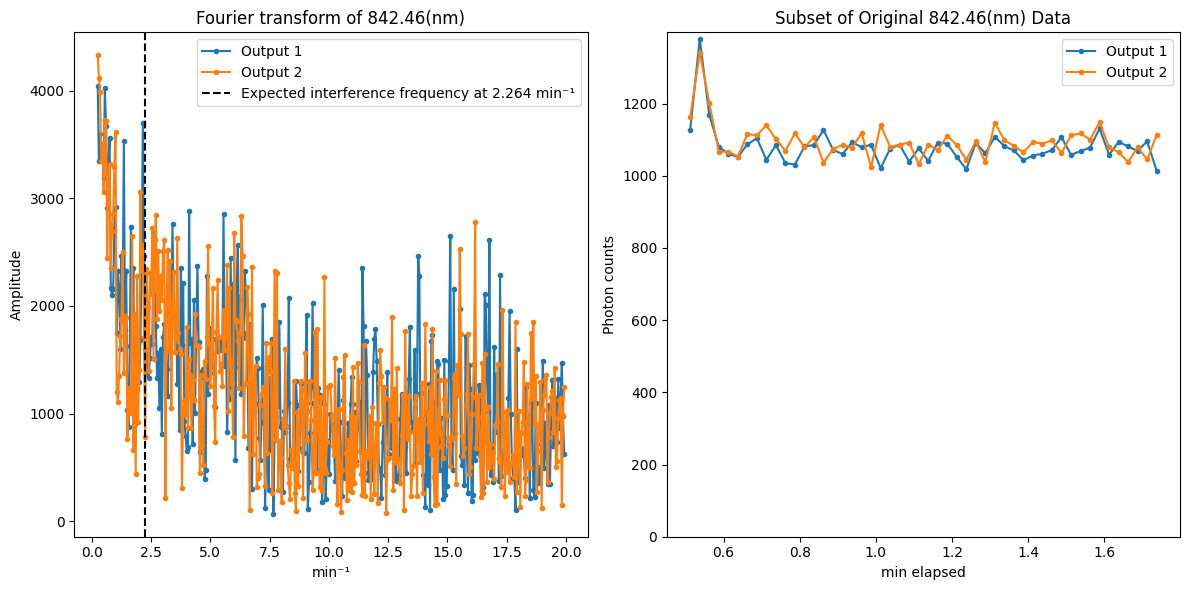

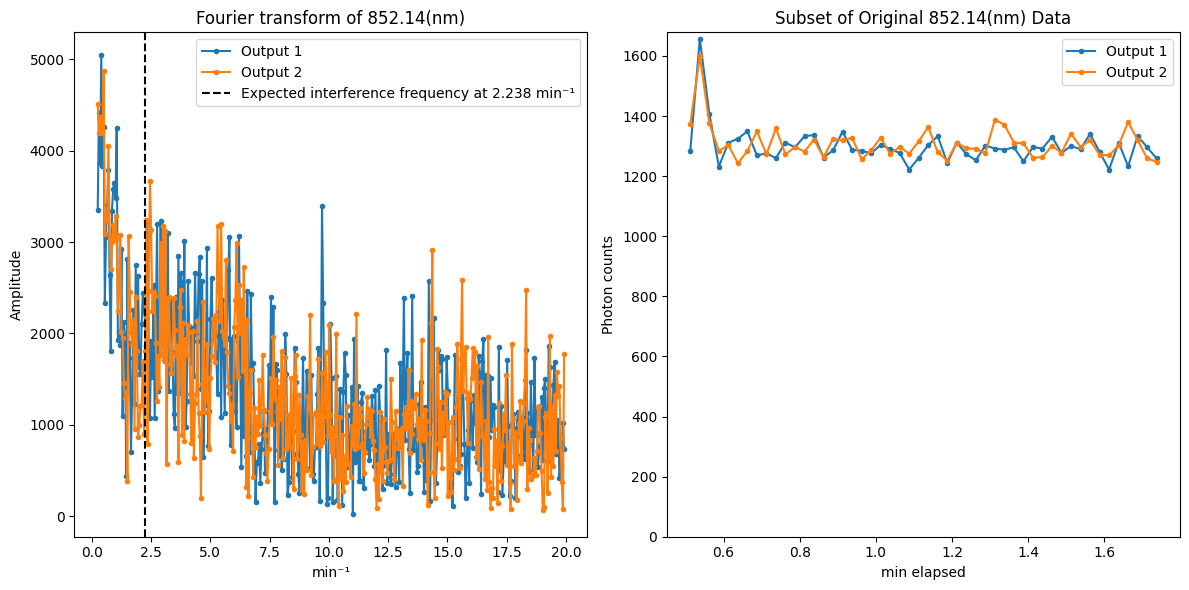

In [25]:
for i, spot in spot_df.iloc[::2].iterrows():
    fft_fig = plt.figure(figsize = (12, 6))
    
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]

    # Frequency domain
    plt.subplot(121)
    
    # Below plots the modulus of the fft values, and doesn't display points after the nyquist frequency (negative values)
    plt.plot(frequencies[5:model_size//2], np.abs(output_1['fft_vals'][5:model_size//2]), marker='.', label='Output 1')
    plt.plot(frequencies[5:model_size//2], np.abs(output_2['fft_vals'][5:model_size//2]), marker='.', label='Output 2')
    #indexed to ignore the 0-spike

    int_freq = find_int_freq(spot['wavelength(nm)'])
    plt.axvline(x=int_freq, color='Black', ls='--', label=f'Expected interference frequency at {int_freq:.3f} {time_div_label}⁻¹')

    plt.xlabel(f"{time_div_label}⁻¹")
    plt.ylabel("Amplitude")
    plt.title(f"Fourier transform of {output_1['wavelength(nm)']}(nm)")
    plt.legend()

    # Time domain from before being modeled
    #plt.subplot(122)
    #plt.plot(bin_centers_rt, output_1['hist_vals'], marker='.', label=f"Output {output_1['#output']}")
    #plt.plot(bin_centers_rt, output_2['hist_vals'], marker='.', label=f"Output {output_2['#output']}")

    plt.subplot(122) #for to see if there's anti- or *- correlation. must comment axvlines out
    plt.plot(bin_centers_rt[20:70], output_1['hist_vals'][20:70], marker='.', label=f"Output {output_1['#output']}")
    plt.plot(bin_centers_rt[20:70], output_2['hist_vals'][20:70], marker='.', label=f"Output {output_2['#output']}")

    #plt.axvline(x=model_start, color='Black', ls='--')
    #plt.axvline(x=model_end, color='Black', ls='--')

    plt.ylim(bottom=0)

    plt.title(f"Subset of Original {output_1['wavelength(nm)']}(nm) Data")
    plt.xlabel(f"{time_div_label} elapsed")
    plt.ylabel("Photon counts")
    plt.legend()

    fft_fig.tight_layout()
    plt.show()

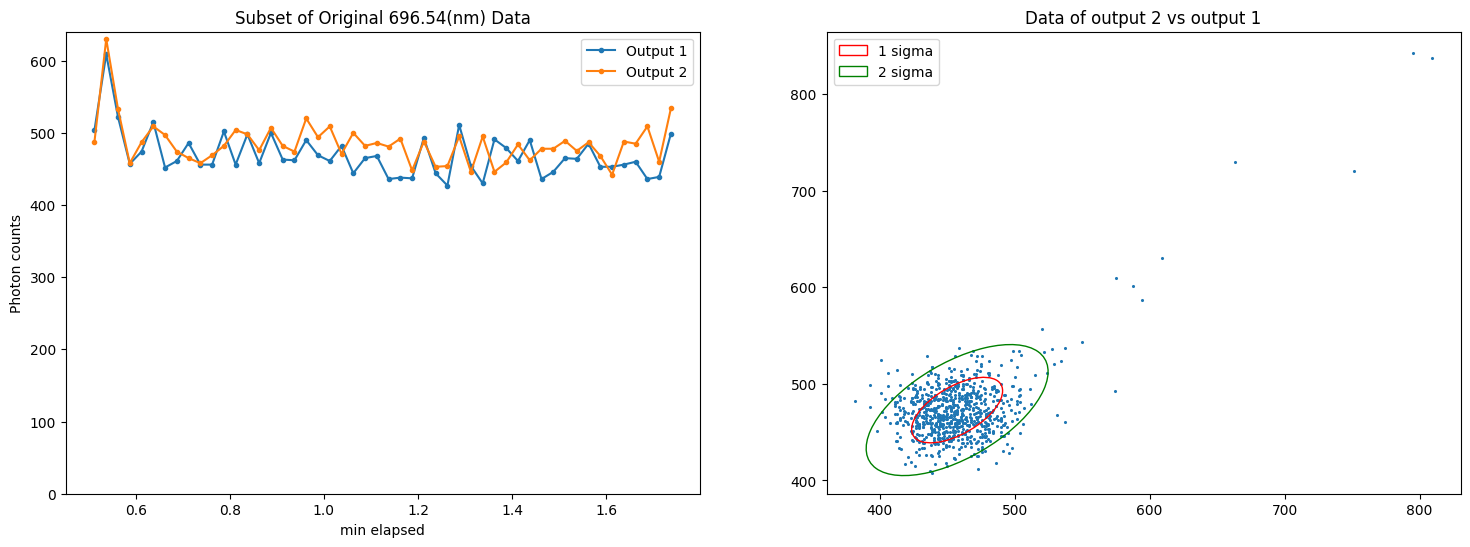

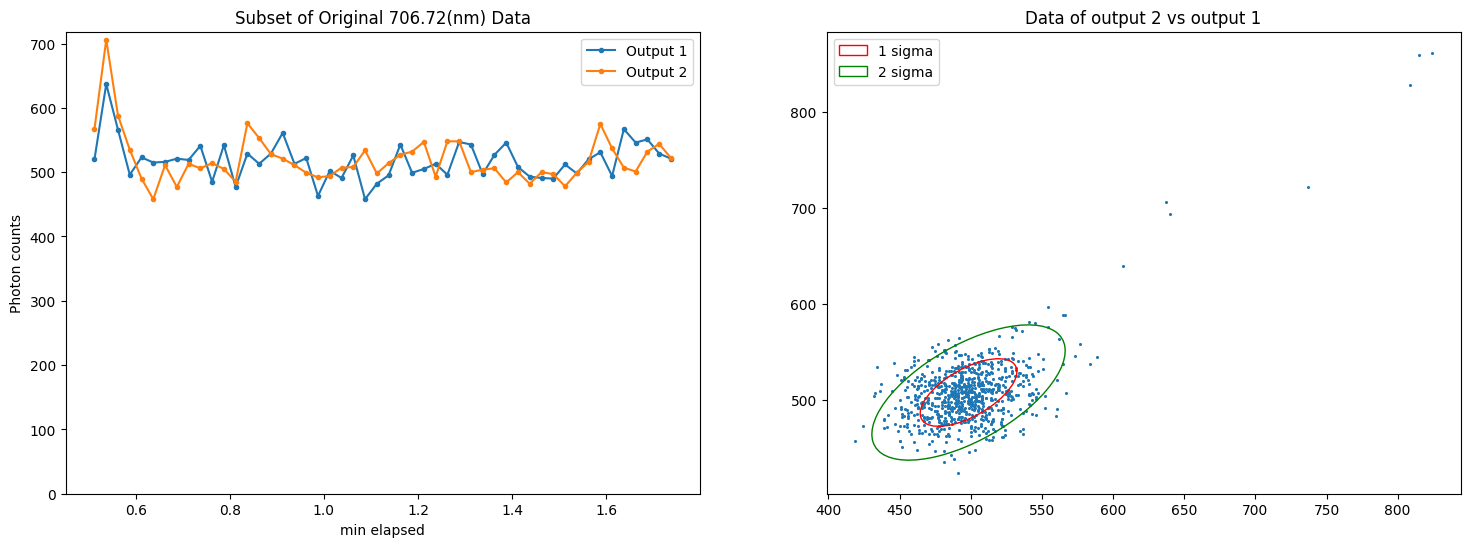

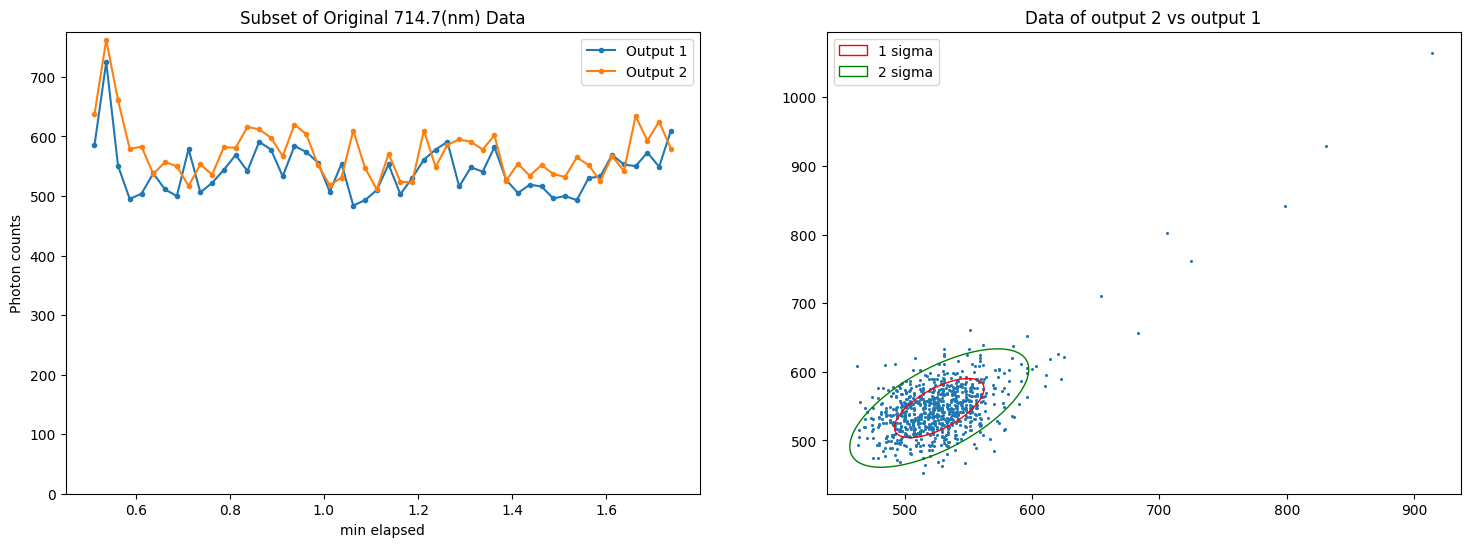

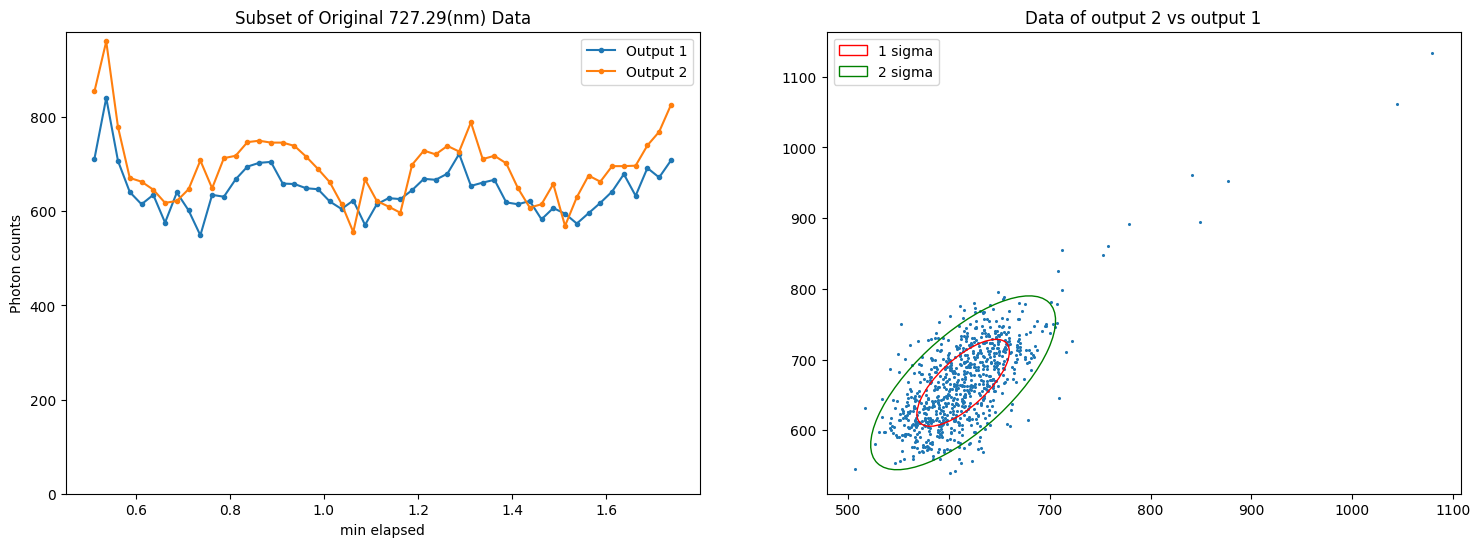

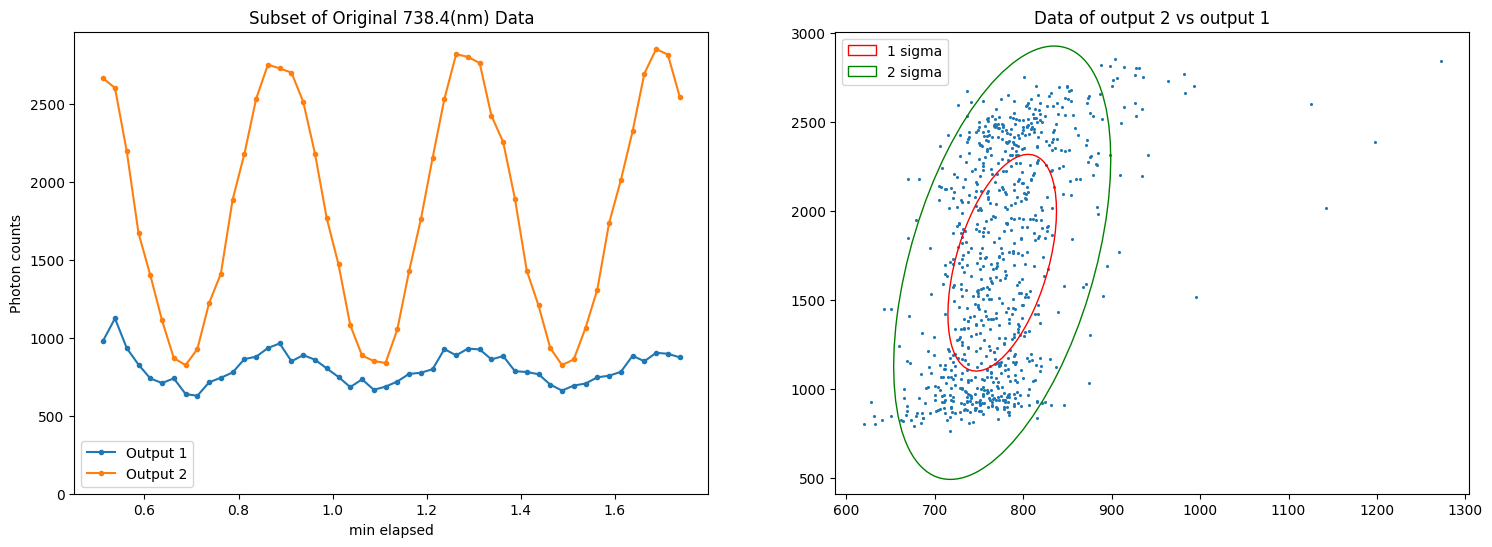

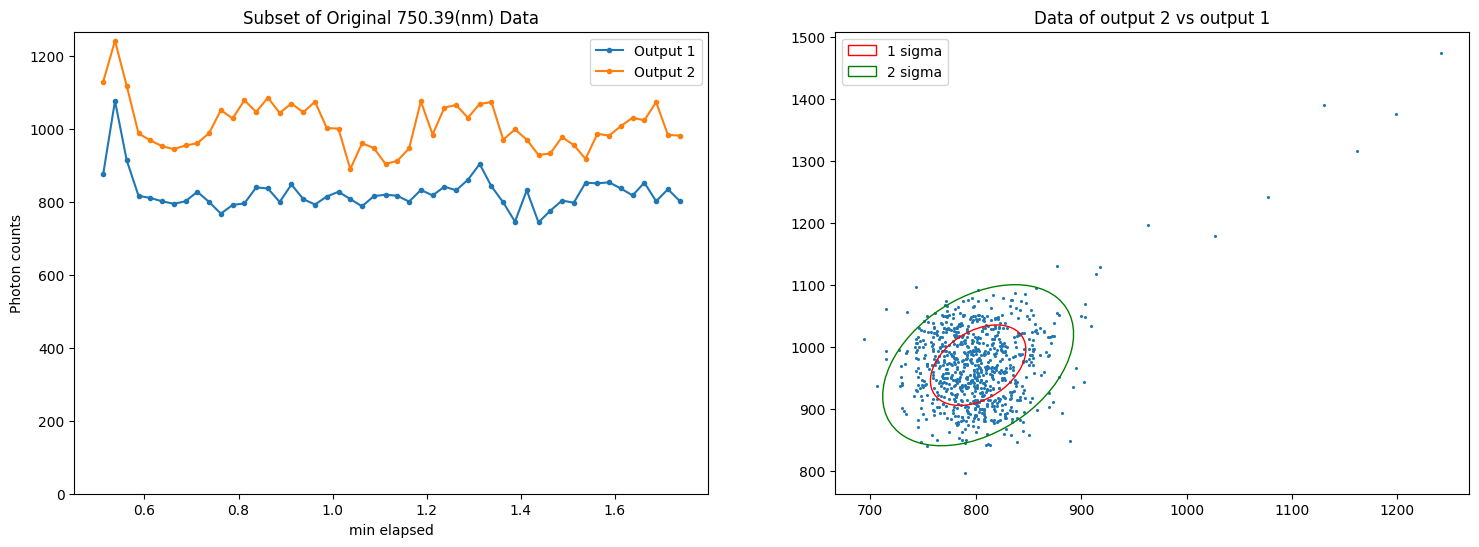

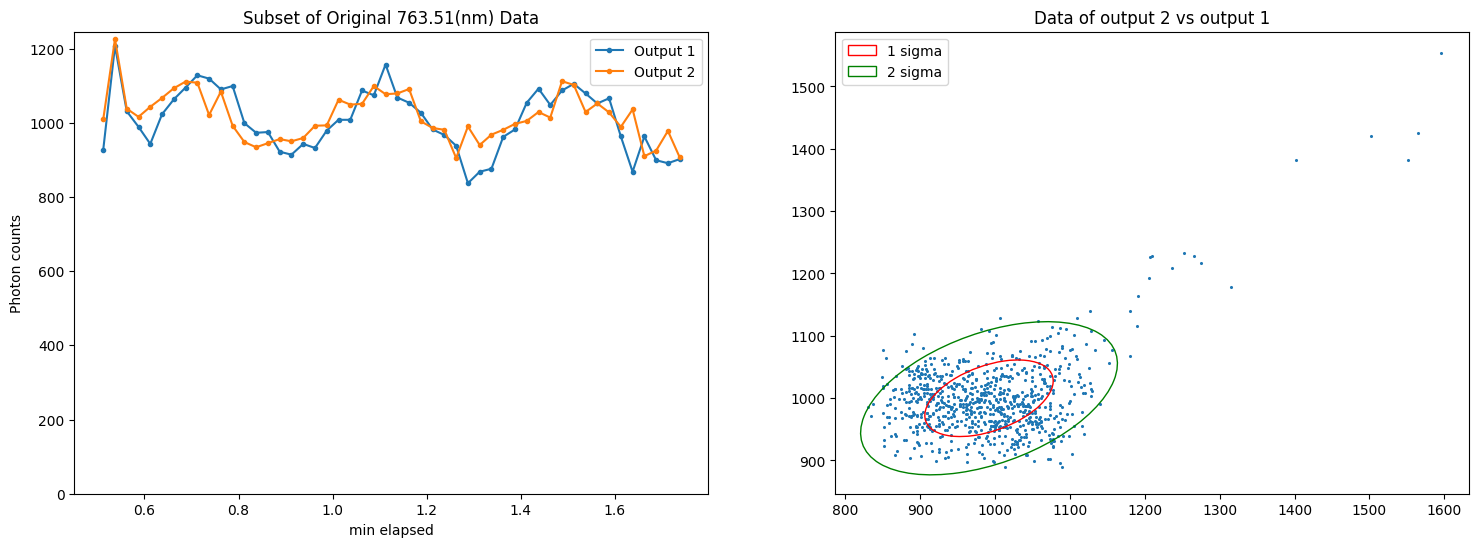

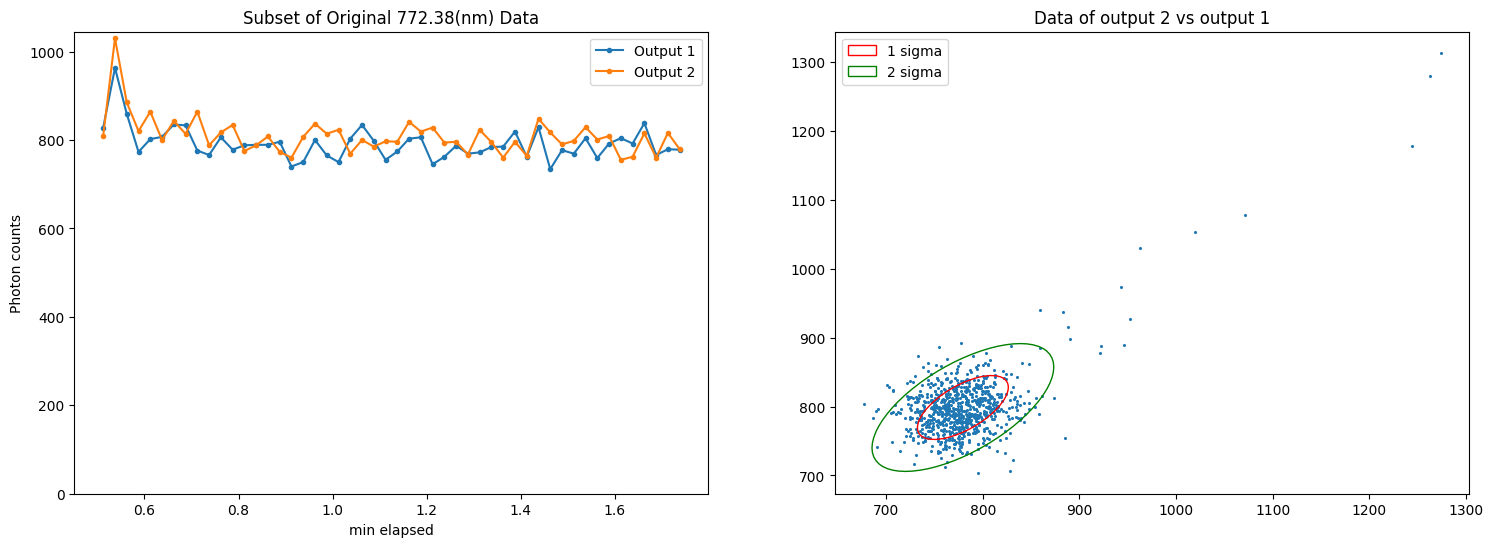

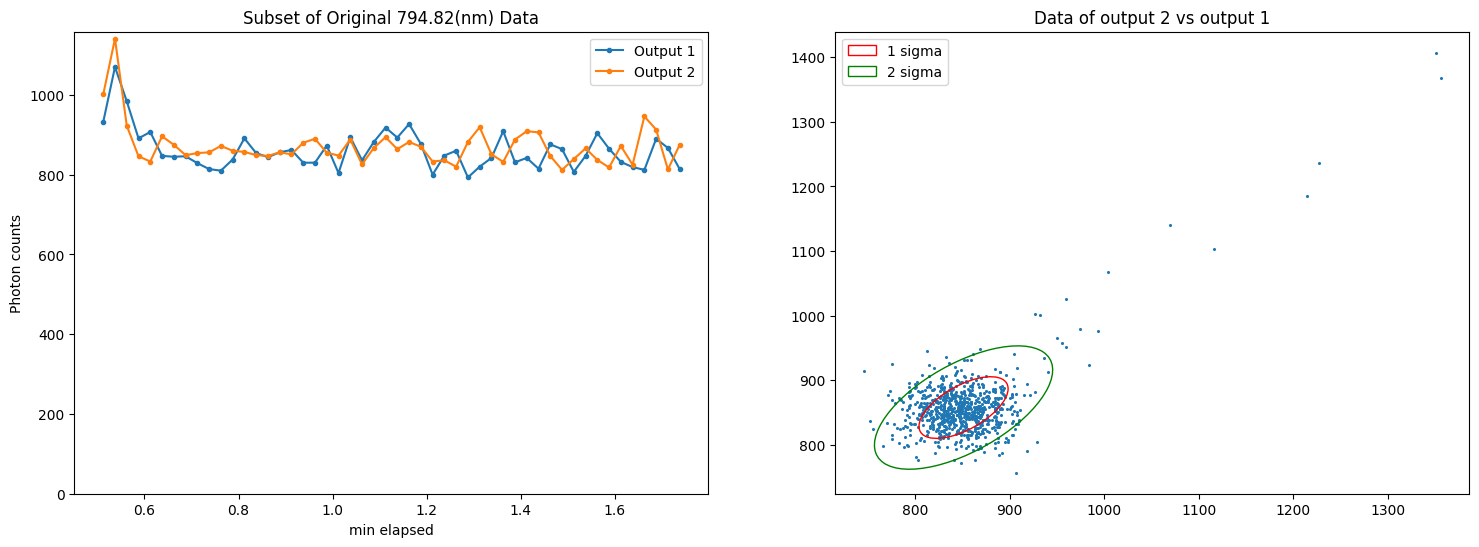

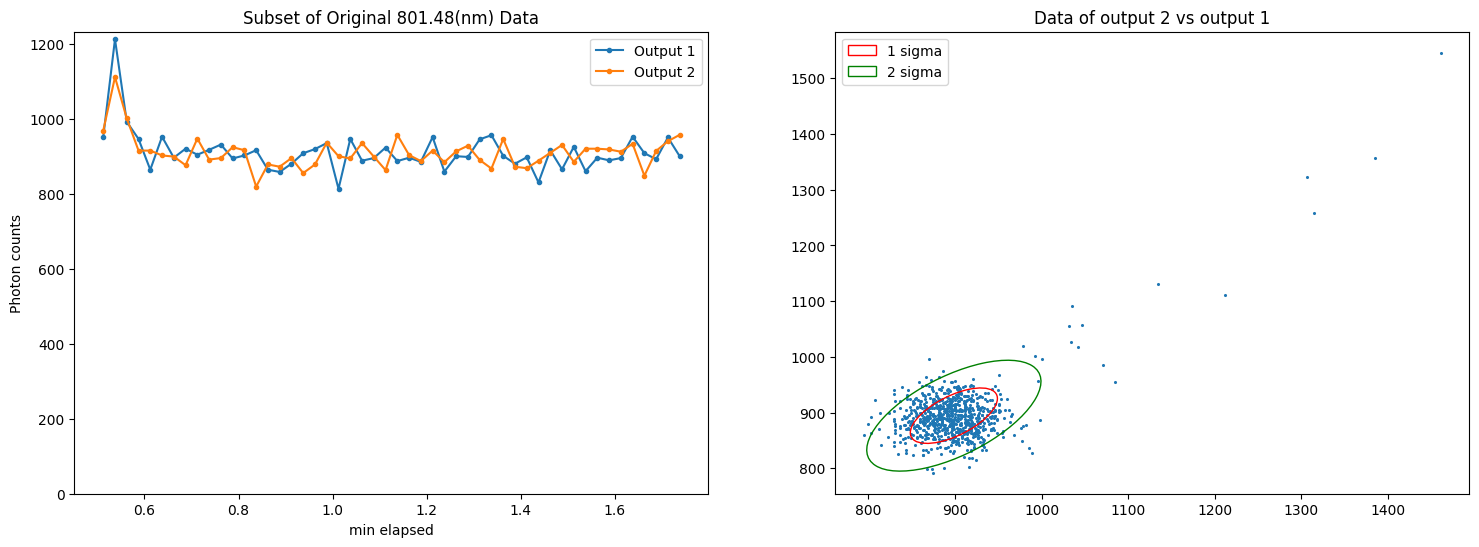

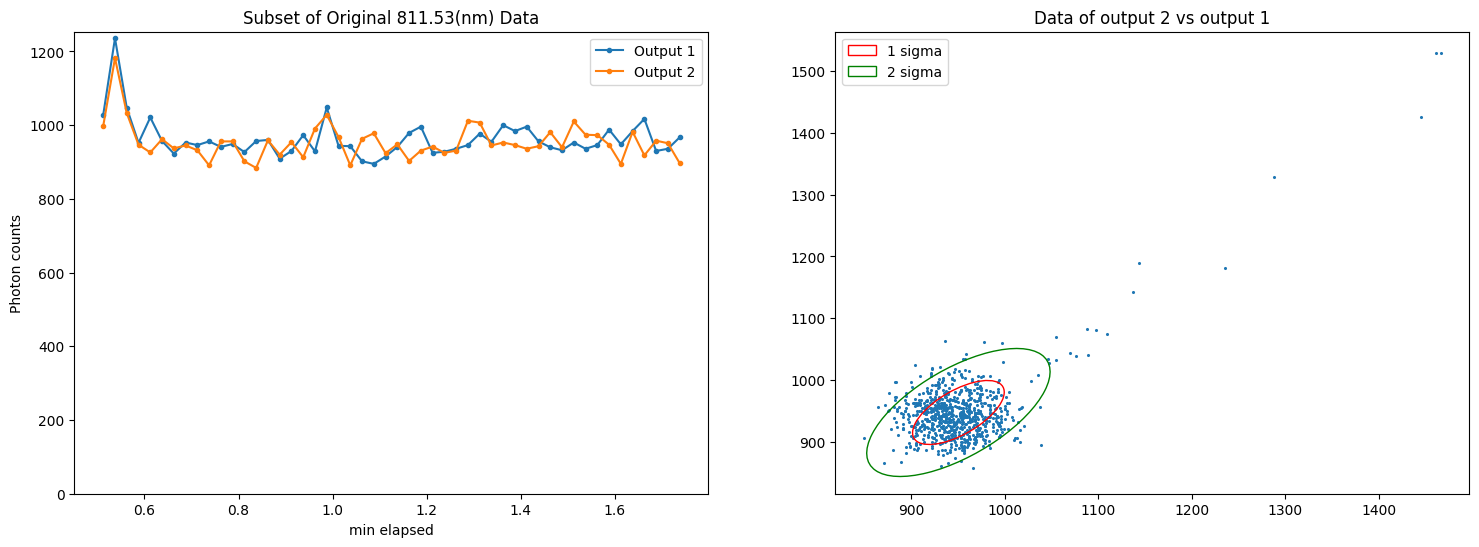

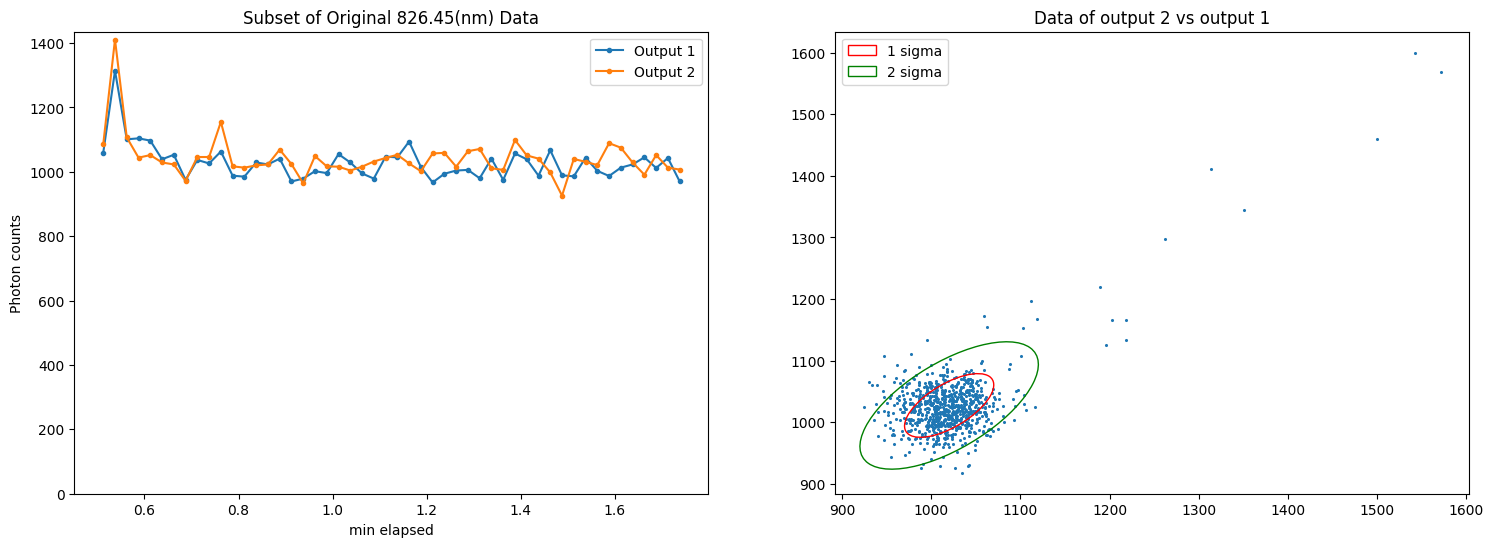

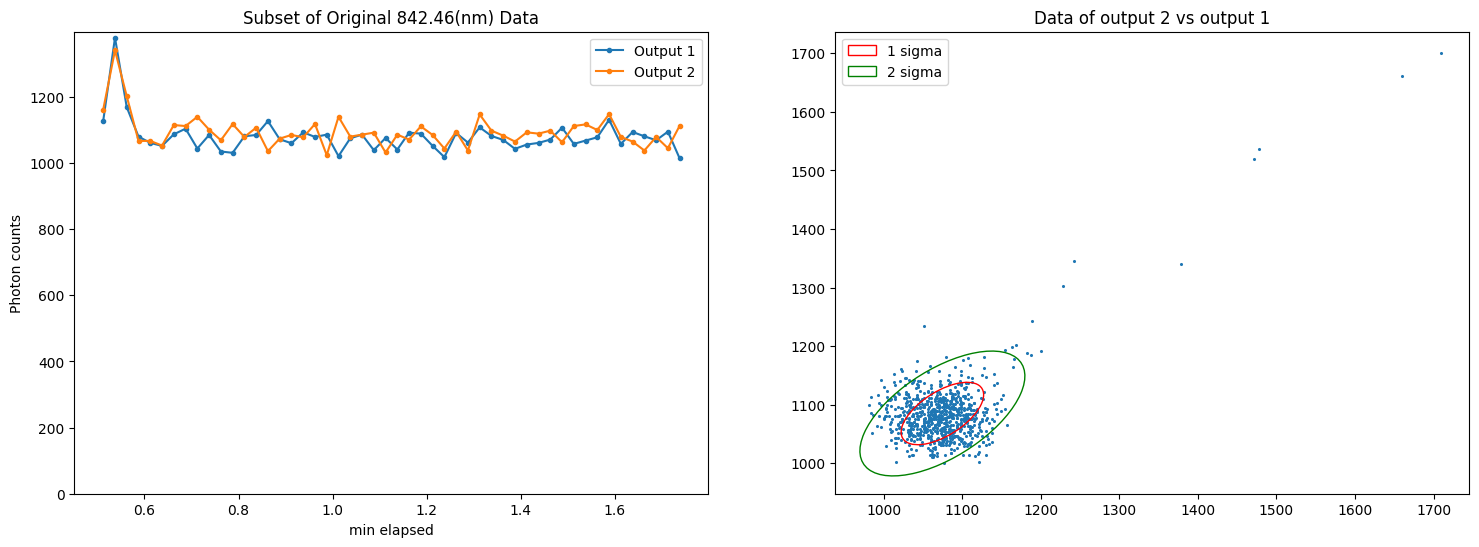

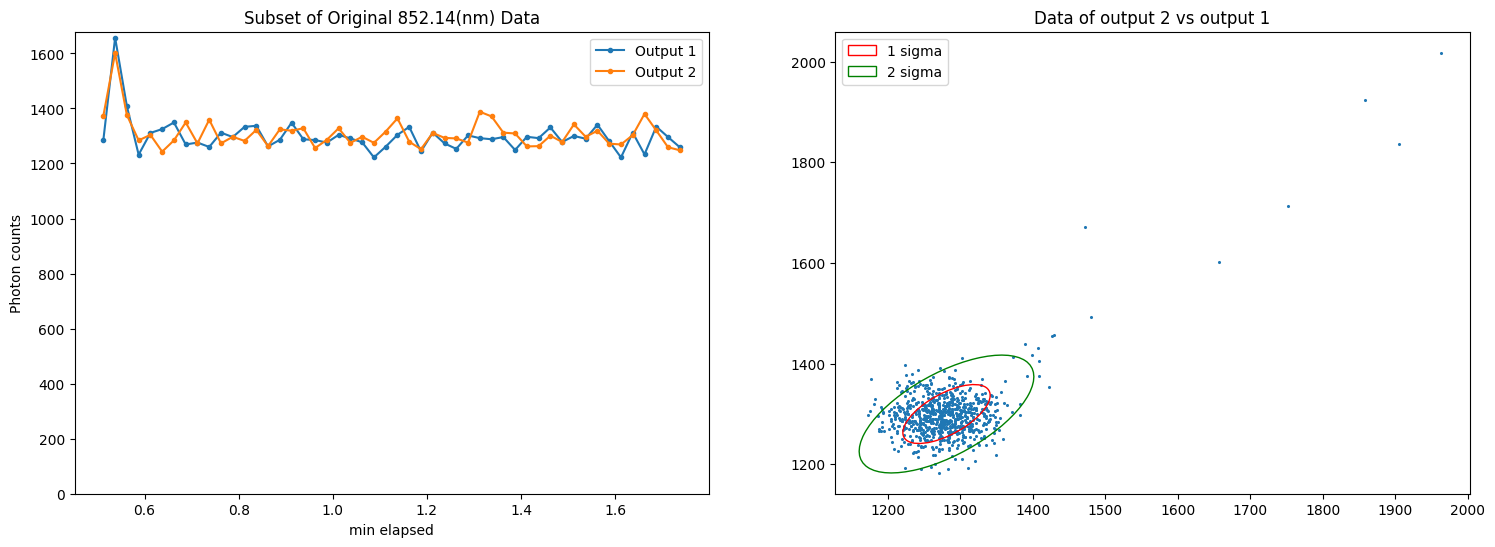

In [53]:
#this block is like the above code, but with an addition for seeing correlation on data.
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
    Input data.
    ax : matplotlib.axes.Axes
    The Axes object to draw the ellipse into.
    n_std : float
    The number of standard deviations to determine the ellipse's radiuses.
    **kwargs
    Forwarded to `~matplotlib.patches.Ellipse`
    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, **kwargs)
    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)


for i, spot in spot_df.iloc[::2].iterrows():
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
    
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]

    #time domain
    ax1 = ax[0]
    ax1.plot(bin_centers_rt[20:70], output_1['hist_vals'][20:70], marker='.', label=f"Output {output_1['#output']}")
    ax1.plot(bin_centers_rt[20:70], output_2['hist_vals'][20:70], marker='.', label=f"Output {output_2['#output']}")
    ax1.set_ylim(bottom=0)
    ax1.set_title(f"Subset of Original {output_1['wavelength(nm)']}(nm) Data")
    ax1.set_xlabel(f"{time_div_label} elapsed")
    ax1.set_ylabel("Photon counts")
    ax1.legend()

    #correlation graph
    ST = 0 #to try to avoid artifacts created on startup or on pauses. the arrays are 800 long in total doing all of
    EN = 799
    #but there are a lot of potential artifacts that may contribute to correlations beyond the MZ ones; background light being one of them.
    #using all data start to finish definitely includes any universal background light spikes, and the pauses.
    ax2 = ax[1]
    ax2.scatter(output_1['hist_vals'][ST:EN],output_2['hist_vals'][ST:EN],s=1.5)
    ax2.set_title(f"Data of output 2 vs output 1")
    confidence_ellipse(output_1['hist_vals'][ST:EN], output_2['hist_vals'][ST:EN], ax2, n_std=1.0,edgecolor='red',label='1 sigma')
    confidence_ellipse(output_1['hist_vals'][ST:EN], output_2['hist_vals'][ST:EN], ax2, n_std=2.0,edgecolor='green',label='2 sigma')
    ax2.legend()


    #fig.tight_layout()
    #plt.show()

In [47]:
len(output_1['hist_vals'])

800

In [78]:
print(len(np.abs(spot['fft_vis_vals'][5:model_size//2]) ), len( np.abs(spot['fft_vis_vals'][:model_size//2]) ) )
df

394 399


np.float64(0.05006257822277849)

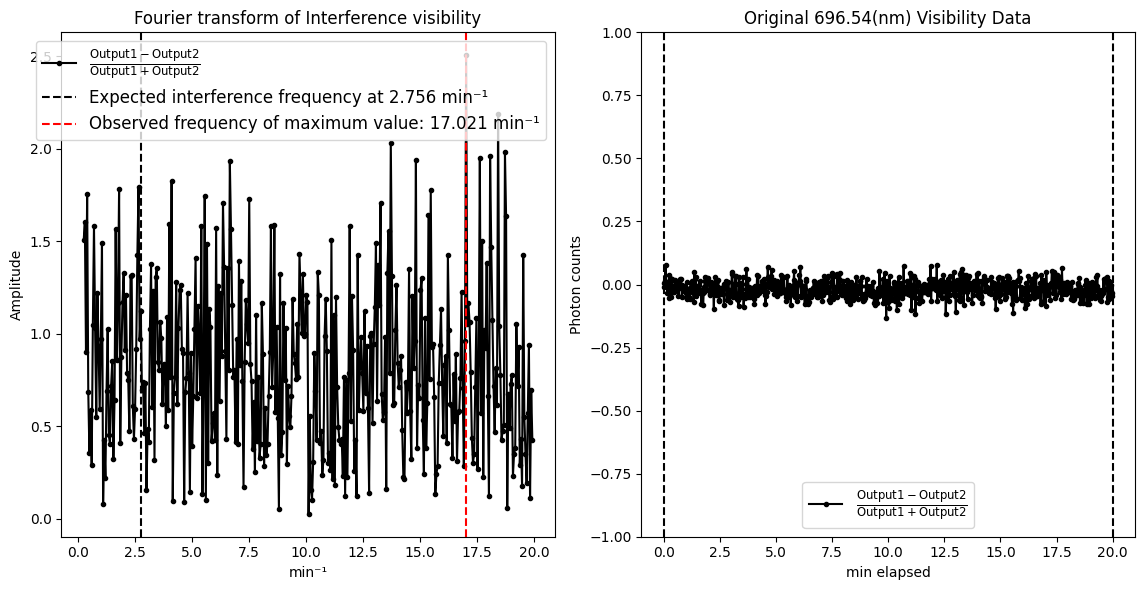

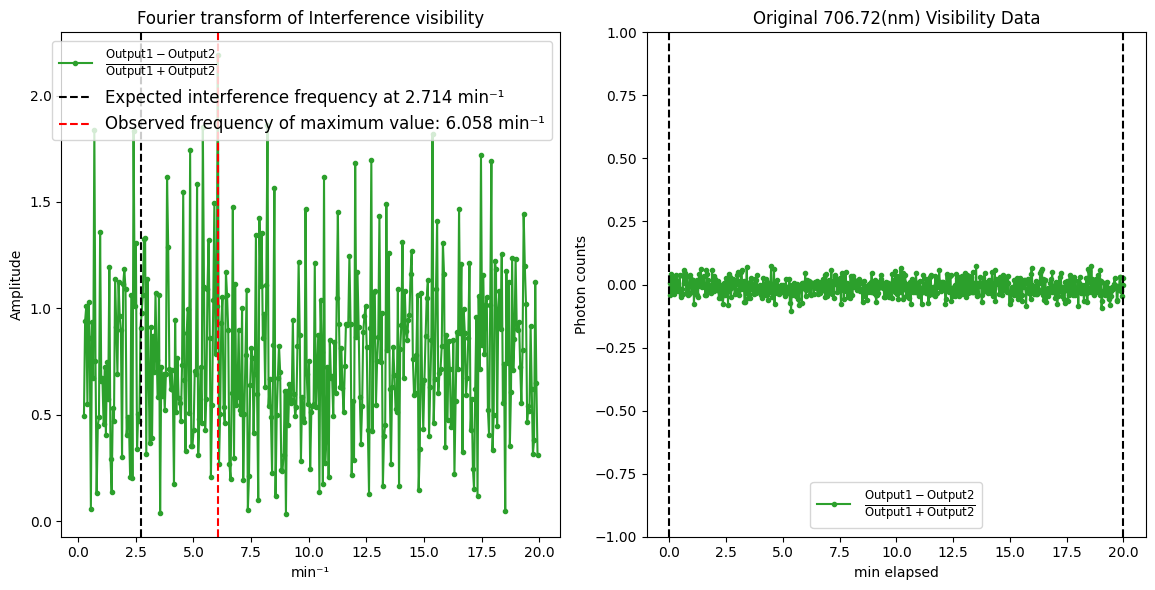

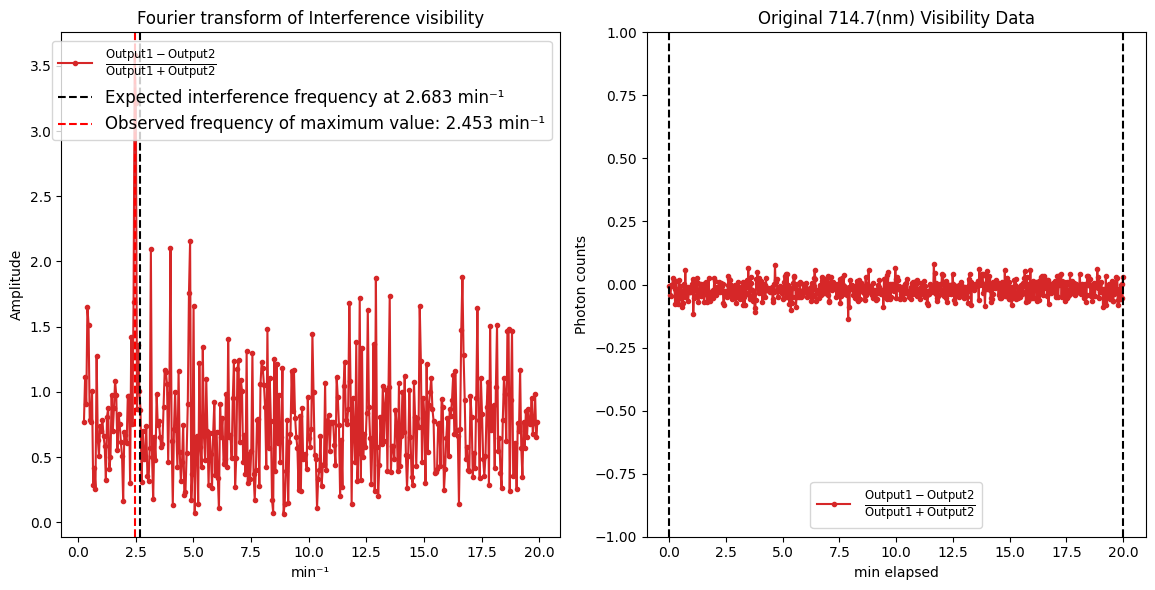

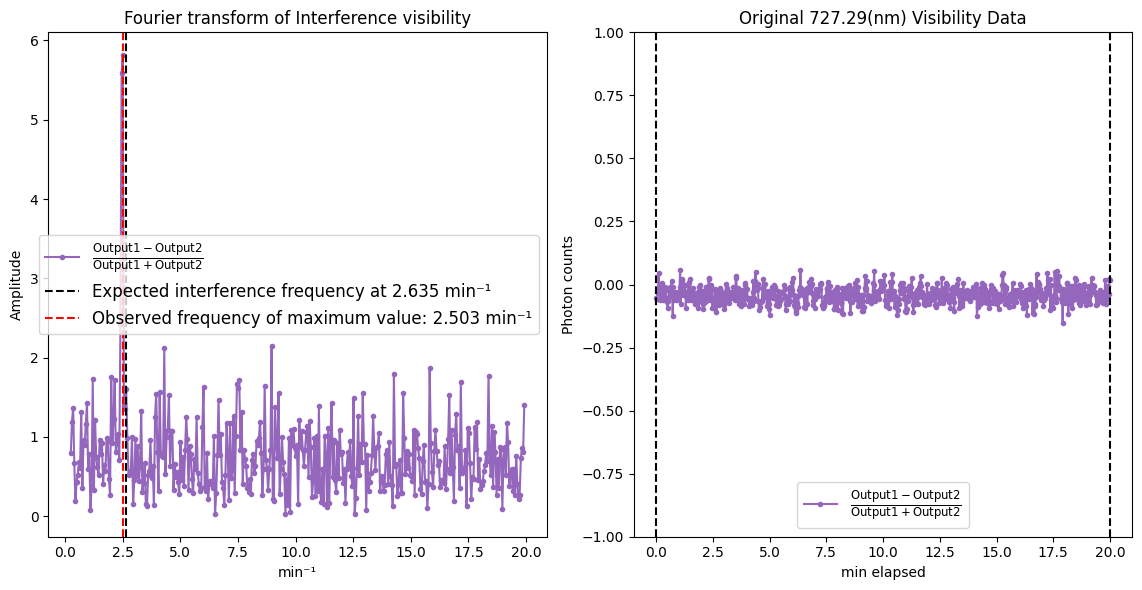

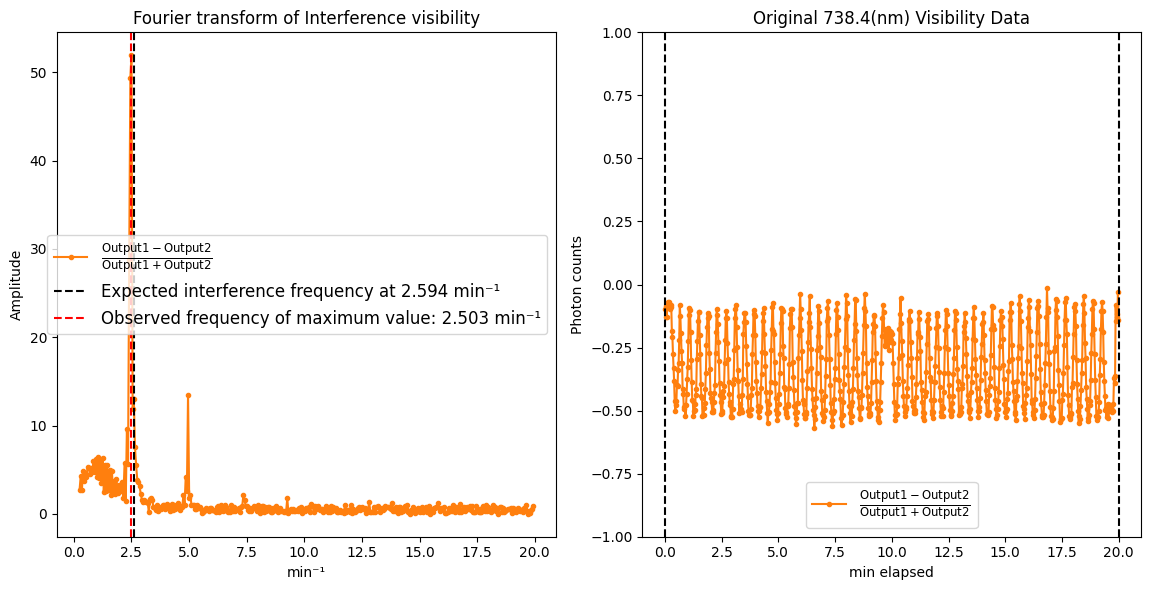

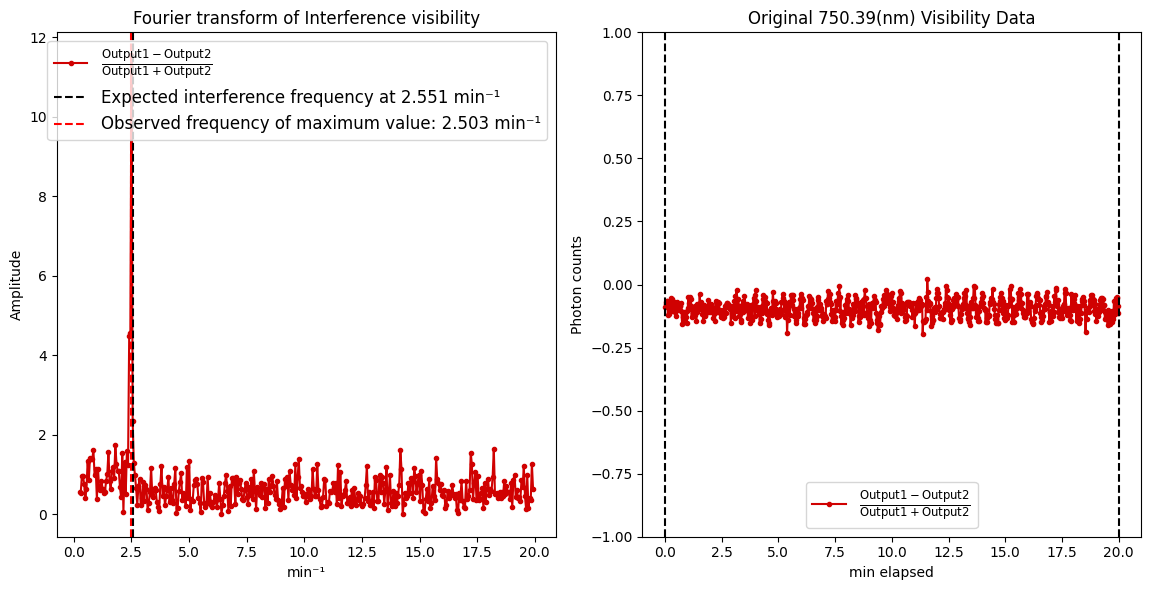

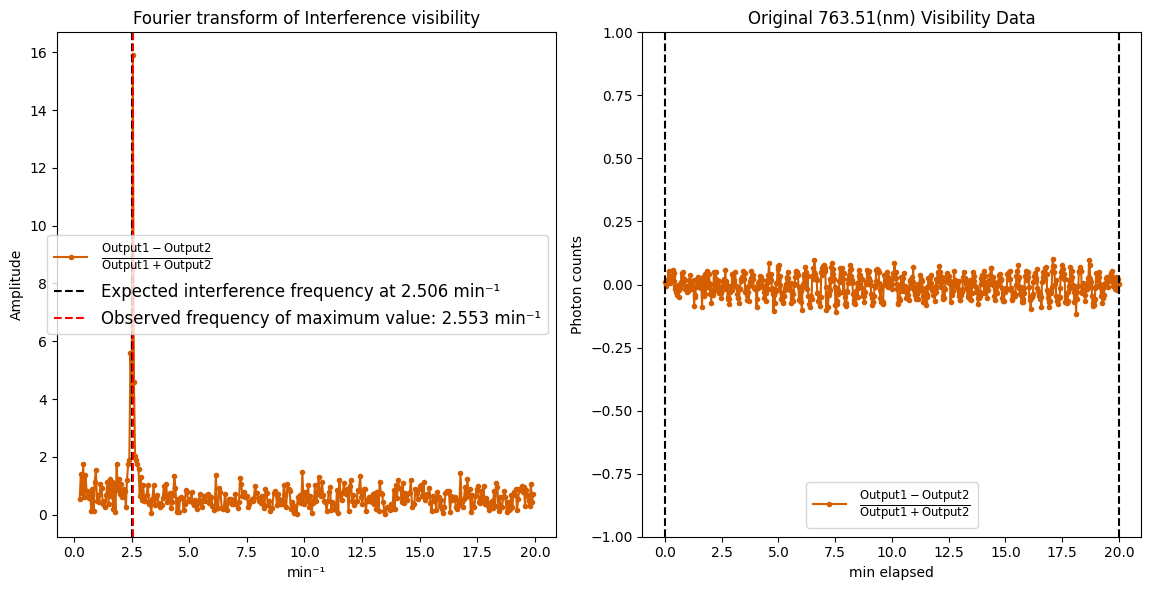

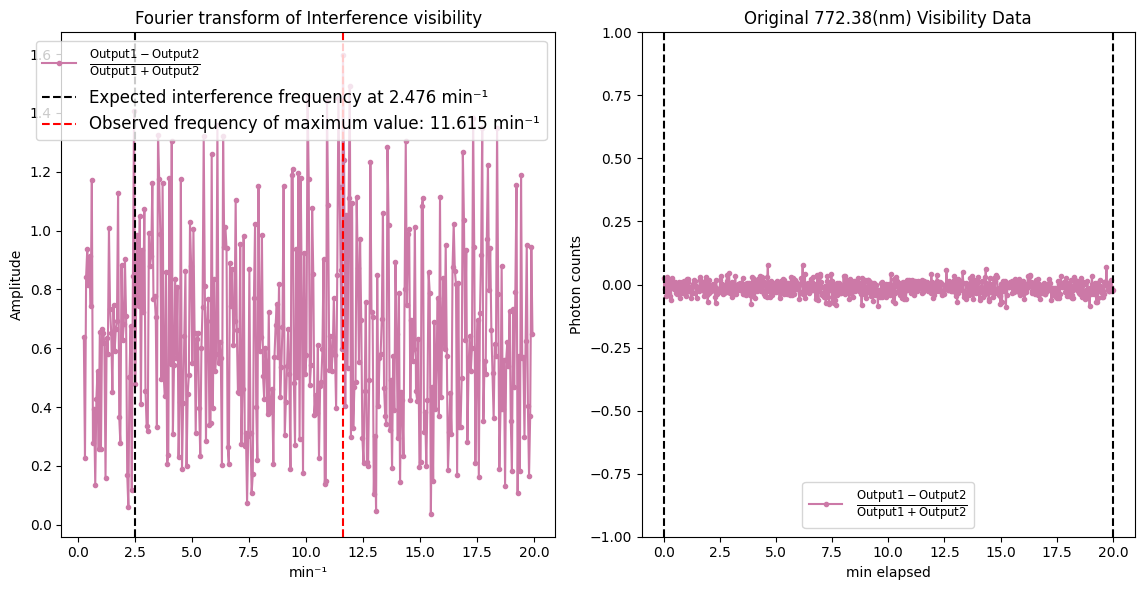

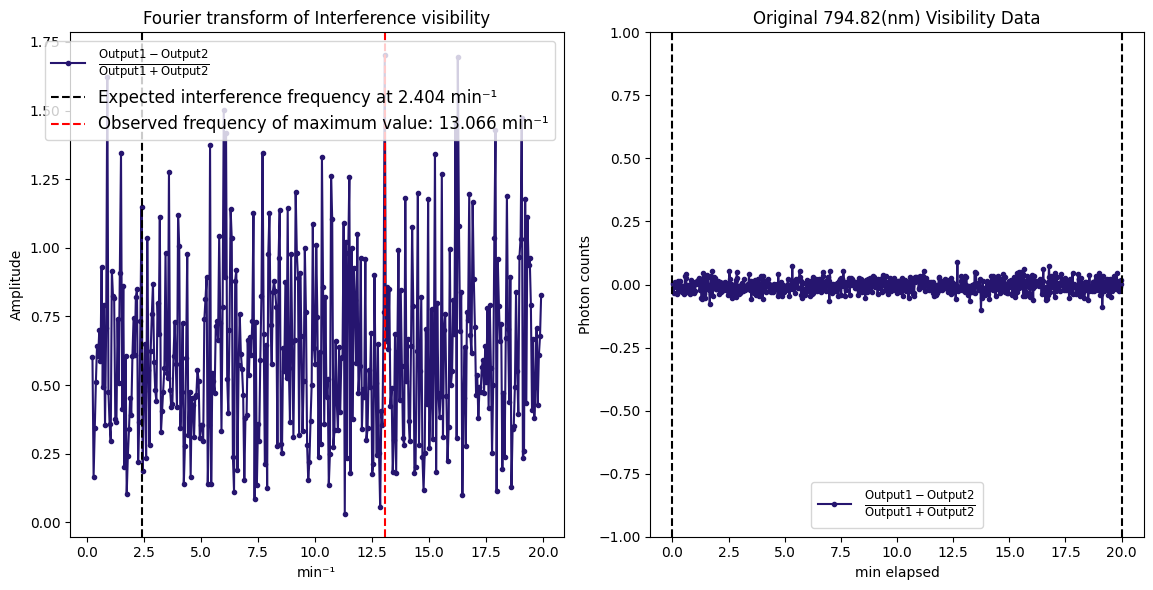

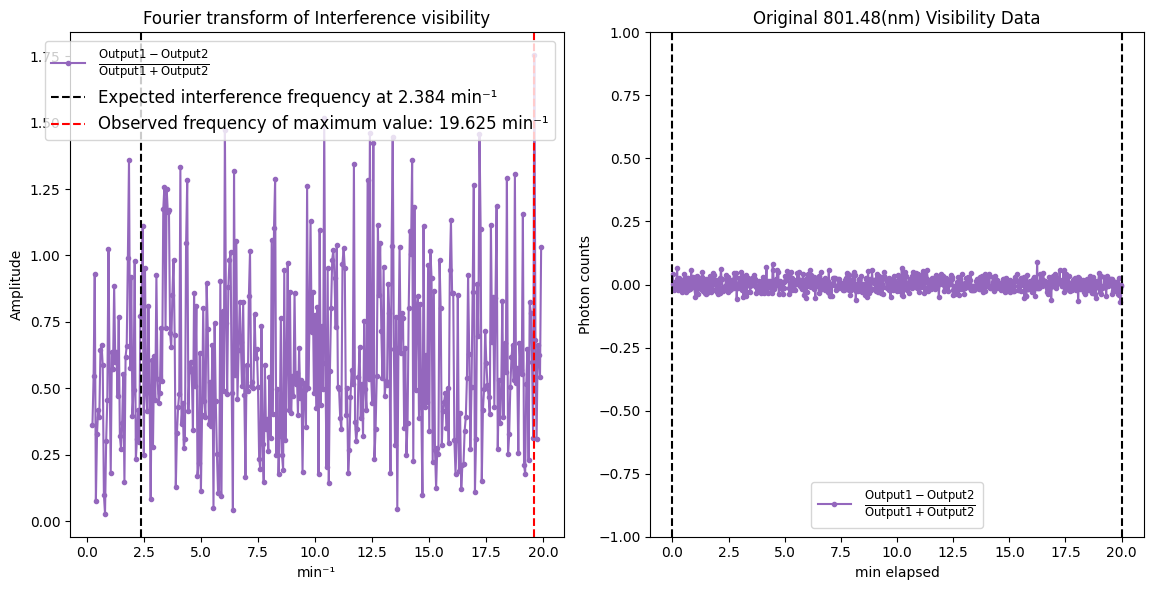

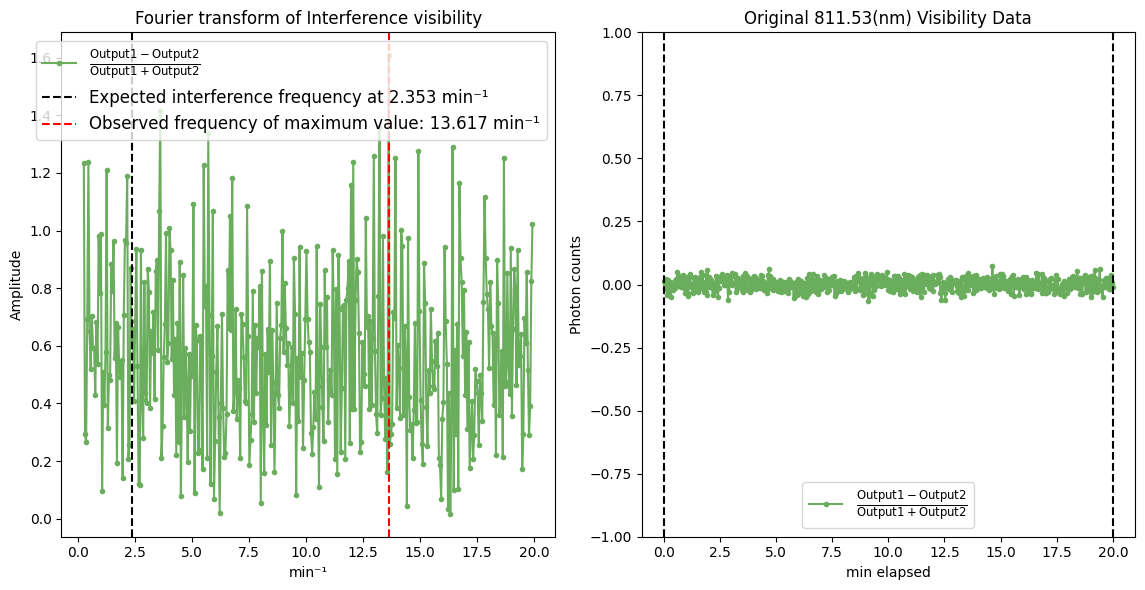

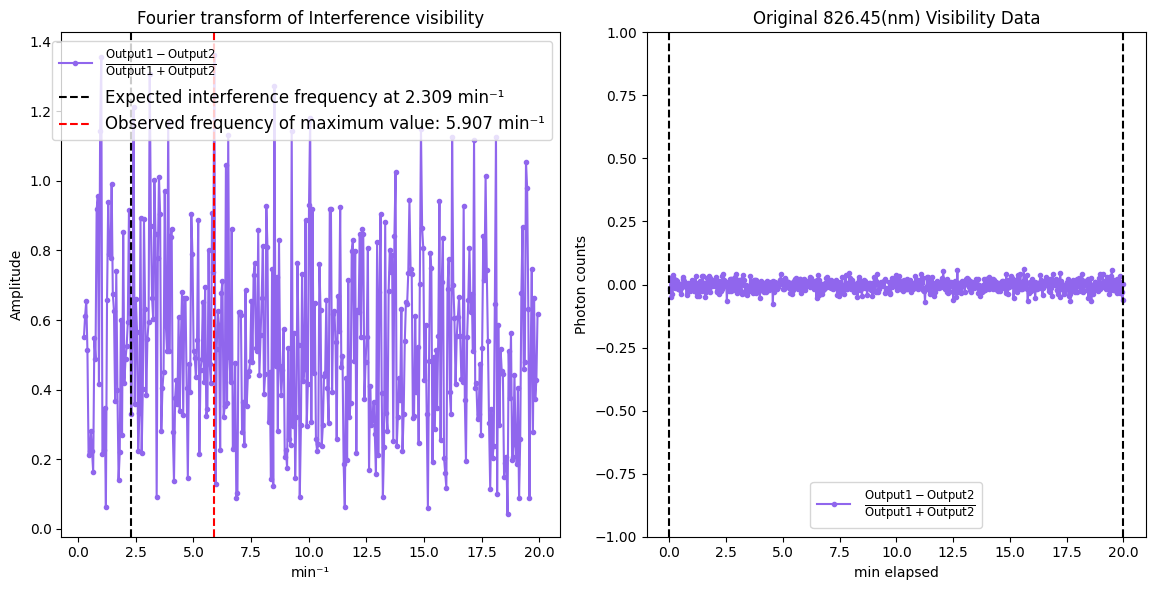

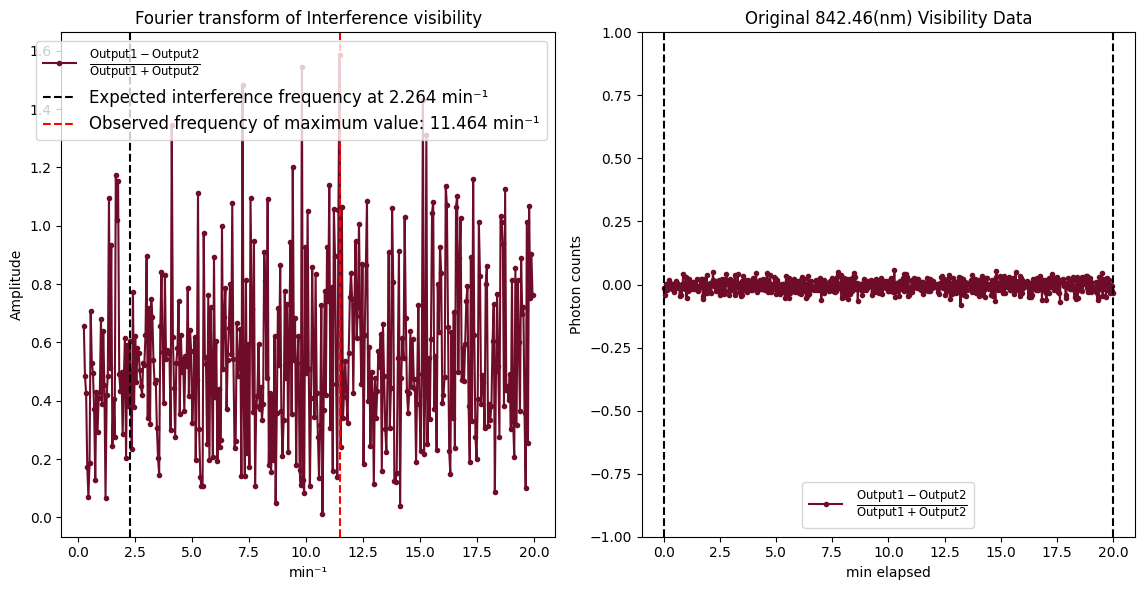

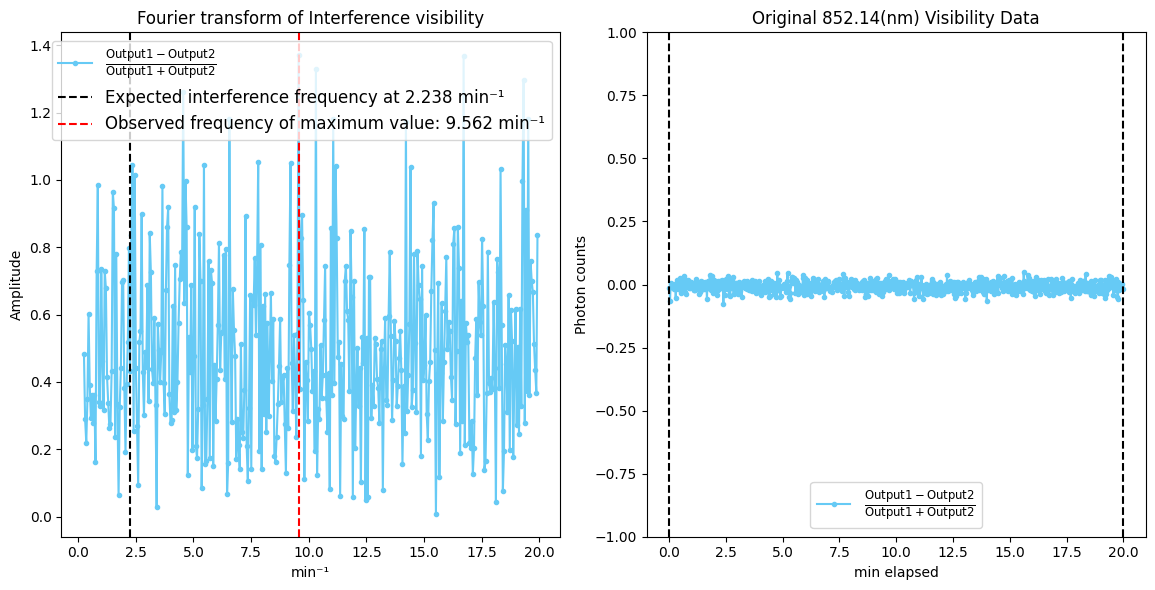

In [77]:
df = frequencies[4] - frequencies[3]
for i, spot in spot_df.iloc[::2].iterrows():
    fft_fig = plt.figure(figsize = (12, 6))

    # Frequency domain
    plt.subplot(121)
    
    # Below plots the modulus of the fft values, and doesn't display points after the nyquist frequency (negative values)
    plt.plot(frequencies[5:model_size//2], np.abs(spot['fft_vis_vals'][5:model_size//2]), marker='.', color=spot['display_color'],
             label=r"$\mathrm{\frac{Output 1 - Output 2}{Output 1 + Output 2}}$")

    int_freq = find_int_freq(spot['wavelength(nm)'])
    plt.axvline(x=int_freq, color='Black', ls='--', label=f'Expected interference frequency at {int_freq:.3f} {time_div_label}⁻¹')

    #finding the actual maximum value observed
    f_of_max_val = (np.abs(spot['fft_vis_vals'][5:model_size//2]).argmax() +5)* df
    
    plt.axvline(x=f_of_max_val,color='red',ls='--',label=f'Observed frequency of maximum value: {f_of_max_val:.3f} {time_div_label}⁻¹')
    #need I add a 5?
    #
    
    #plt.ylim(0, 25)
    plt.xlabel(f"{time_div_label}⁻¹")
    plt.ylabel("Amplitude")
    plt.title(f"Fourier transform of Interference visibility")
    plt.legend(fontsize='large')

    # Time domain from before being modeled
    plt.subplot(122)
    plt.plot(bin_centers_rt, spot['vis_vals'], marker='.', color=spot['display_color'], 
             label=r"$\mathrm{\frac{Output 1 - Output 2}{Output 1 + Output 2}}$")

    plt.axvline(x=model_start, color='Black', ls='--')
    plt.axvline(x=model_end, color='Black', ls='--')

    plt.ylim(-1, 1)

    plt.title(f"Original {spot['wavelength(nm)']}(nm) Visibility Data")
    plt.xlabel(f"{time_div_label} elapsed")
    plt.ylabel("Photon counts")
    plt.legend(fontsize='large')

    fft_fig.tight_layout()
    plt.show()

[0.16134988 0.72932523 0.98377087 0.34153541 0.32866214 0.73448147
 0.46204793 0.31570934 0.73024774 0.67926481 0.41571741 0.33685903
 0.26399502 0.27630233 0.43316089 0.964128   0.91605571 0.23499382
 0.77935185 0.33321342 0.06345405 0.32630748 0.44257116 0.69716082
 0.70352239 0.38329464 0.19221206 0.39529833 0.5187701  0.7993345
 0.43347009 0.8351701  1.04306062 0.25409513 1.01596992 0.440753
 0.26791557 0.09375699 0.51887248 0.55113268 0.89970075 0.43037276
 0.30203519 0.48785158 0.44435503 0.68907574 0.34284632 0.84118406
 0.7252025  0.43705661 0.39634917 0.58902077 0.33002017 0.02808685
 0.57351131 0.49411039 0.39947101 0.48984027 0.98284596 0.39810091
 0.30447146 0.67217501 0.86005205 0.91824434 0.36370872 0.27779734
 0.28756223 0.62649056 0.31095153 0.7470625  0.31739997 0.39844897
 0.57603734 0.70482115 0.78623133 0.71211166 1.26211151 0.63551038
 0.99639869 0.85982038 0.12398114 0.53442883 0.43054121 0.68869512
 0.19911798 0.47599216 0.92027511 0.21079709 0.17362023 0.3204525

In [56]:
arry = np.array([1,2,3,4,5,6,7,800,9,10])
print(arry.argmax() + 1.)

8.0
